## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Load All Datasets

In [2]:
# Load all datasets
data_path = '../data/raw/'

beneficiary_df = pd.read_csv(data_path + 'Train_Beneficiarydata-1542865627584.csv')
inpatient_df = pd.read_csv(data_path + 'Train_Inpatientdata-1542865627584.csv')
outpatient_df = pd.read_csv(data_path + 'Train_Outpatientdata-1542865627584.csv')
labels_df = pd.read_csv(data_path + 'Train-1542865627584.csv')
test_inpatient_df = pd.read_csv(data_path + 'Test_Inpatientdata-1542969243754.csv')
test_outpatient_df = pd.read_csv(data_path + 'Test_Outpatientdata-1542969243754.csv')
test_labels_df = pd.read_csv(data_path + 'Test-1542969243754.csv')

## 3. Cleaning Beneficiary.csv


In [3]:
# Load beneficiary data
import os

Train_Beneficiarydata = pd.read_csv("../data/raw/Train_Beneficiarydata-1542865627584.csv")
Test_Beneficiarydata  = pd.read_csv("../data/raw/Test_Beneficiarydata-1542969243754.csv")

print(f"Train shape: {Train_Beneficiarydata.shape}")
print(f"Test shape: {Test_Beneficiarydata.shape}")

binary_replace_cols = [
    'Gender','ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease',
    'ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis',
    'ChronicCond_stroke'
]

Train_Beneficiarydata[binary_replace_cols] = Train_Beneficiarydata[binary_replace_cols].replace(2, 0)
Test_Beneficiarydata[binary_replace_cols]  = Test_Beneficiarydata[binary_replace_cols].replace(2, 0)

# Renal Disease: convert 'Y' to 1
Train_Beneficiarydata['RenalDiseaseIndicator'] = Train_Beneficiarydata['RenalDiseaseIndicator'].replace({'Y':1})
Test_Beneficiarydata['RenalDiseaseIndicator']  = Test_Beneficiarydata['RenalDiseaseIndicator'].replace({'Y':1})

# Convert dates
Train_Beneficiarydata['DOB'] = pd.to_datetime(Train_Beneficiarydata['DOB'], errors='coerce')
Train_Beneficiarydata['DOD'] = pd.to_datetime(Train_Beneficiarydata['DOD'], errors='coerce')
Test_Beneficiarydata['DOB'] = pd.to_datetime(Test_Beneficiarydata['DOB'], errors='coerce')
Test_Beneficiarydata['DOD'] = pd.to_datetime(Test_Beneficiarydata['DOD'], errors='coerce')

Train_Beneficiarydata['Age'] = (Train_Beneficiarydata['DOD']-Train_Beneficiarydata['DOB']).dt.days // 365
Test_Beneficiarydata['Age'] = (Test_Beneficiarydata['DOD']-Test_Beneficiarydata['DOB']).dt.days // 365

# Fill alive patients with dataset's  (last death was 1/12/2009) - DOB 
Test_Beneficiarydata['Age']=Test_Beneficiarydata['Age'].fillna((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - Test_Beneficiarydata['DOB']).dt.days // 365)
Train_Beneficiarydata['Age']=Train_Beneficiarydata['Age'].fillna((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - Train_Beneficiarydata['DOB']).dt.days // 365)

Train_Beneficiarydata["IsDeceased"] = Train_Beneficiarydata["DOD"].notna().astype(int)
Test_Beneficiarydata["IsDeceased"]  = Test_Beneficiarydata["DOD"].notna().astype(int)

# Drop raw date columns
Train_Beneficiarydata = Train_Beneficiarydata.drop(columns=["DOB","DOD"]) 
Test_Beneficiarydata  = Test_Beneficiarydata.drop(columns=["DOB","DOD"]) 

# Save cleaned data
os.makedirs("../data/processed", exist_ok=True)
Train_Beneficiarydata.to_csv("../data/processed/Train_Beneficiarydata_cleaned.csv", index=False)
Test_Beneficiarydata.to_csv("../data/processed/Test_Beneficiarydata_cleaned.csv", index=False)

print("Cleaned beneficiary data saved to ../data/processed/")
print(f"Train cleaned shape: {Train_Beneficiarydata.shape}")
print(f"Test cleaned shape: {Test_Beneficiarydata.shape}")
print(Train_Beneficiarydata.head(5))

Train shape: (138556, 25)
Test shape: (63968, 25)
Cleaned beneficiary data saved to ../data/processed/
Train cleaned shape: (138556, 25)
Test cleaned shape: (63968, 25)
      BeneID  Gender  Race RenalDiseaseIndicator  State  County  \
0  BENE11001       1     1                     0     39     230   
1  BENE11002       0     1                     0     39     280   
2  BENE11003       1     1                     0     52     590   
3  BENE11004       1     1                     0     39     270   
4  BENE11005       1     1                     0     24     680   

   NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0                   12                   12                      1   
1                   12                   12                      0   
2                   12                   12                      1   
3                   12                   12                      1   
4                   12                   12                      0   

   Chro

In [4]:
# ============================================================
# SIMPLE & CLEAN DATA QUALITY ASSESSMENT - INPATIENT
# ============================================================

import pandas as pd

# Load raw inpatient file
df = pd.read_csv("../data/raw/Train_Inpatientdata-1542865627584.csv")

print("="*60)
print("INPATIENT DATA QUALITY SUMMARY")
print("="*60)

# 1. Shape & Info
print("\n1️⃣ BASIC INFO")
print(f"Rows: {df.shape[0]:,}  |  Columns: {df.shape[1]}")
print("Memory Usage: {:.2f} MB".format(df.memory_usage(deep=True).sum()/1024**2))

# 2. Missing values
print("\n2️⃣ MISSING VALUES")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if missing.empty:
    print("No missing values.")
else:
    print(missing.to_string())

# 3. Duplicates
print("\n3️⃣ DUPLICATES")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print(f"Duplicate ClaimID: {df['ClaimID'].duplicated().sum()}")

# 4. Numeric Range Checks
print("\n4️⃣ NUMERIC RANGES")
num_cols = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
    'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
    'OPAnnualReimbursementAmt','OPAnnualDeductibleAmt'
]

for col in num_cols:
    if col in df.columns:
        vals = pd.to_numeric(df[col], errors='coerce')
        print(f"{col}: Min={vals.min()}, Max={vals.max()}, Negatives={(vals<0).sum()}")

# 5. Date Validation
print("\n5️⃣ DATE VALIDATION")
date_cols = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt']
for col in date_cols:
    if col in df.columns:
        d = pd.to_datetime(df[col], errors='coerce')
        print(f"{col}: Range {d.min()} → {d.max()} | Invalid: {(d.isna() & df[col].notna()).sum()}")

# 6. Cardinality of Important IDs
print("\n6️⃣ KEY COLUMN CARDINALITY")
key_cols = ['Provider','BeneID','ClaimID','AttendingPhysician','OperatingPhysician','OtherPhysician']
for col in key_cols:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique | Nulls: {df[col].isna().mean()*100:.1f}%")

# 7. Diagnosis / Procedure completeness
print("\n7️⃣ DIAGNOSIS & PROCEDURE COMPLETENESS")
diag_cols = [c for c in df.columns if 'ClmDiagnosisCode' in c]
proc_cols = [c for c in df.columns if 'ClmProcedureCode' in c]

diag_count = df[diag_cols].notna().sum(axis=1)
proc_count = df[proc_cols].notna().sum(axis=1)

print(f"Diagnosis codes per claim → Min={diag_count.min()}, Max={diag_count.max()}, Mean={diag_count.mean():.1f}")
print(f"Procedure codes per claim → Min={proc_count.min()}, Max={proc_count.max()}, Mean={proc_count.mean():.1f}")

# 8. Logical Checks
print("\n8️⃣ LOGICAL CONSISTENCY CHECKS")

cs = pd.to_datetime(df['ClaimStartDt'], errors='coerce')
ce = pd.to_datetime(df['ClaimEndDt'], errors='coerce')
print(f"End < Start: {(ce < cs).sum()} claims")

if 'AdmissionDt' in df.columns:
    adm = pd.to_datetime(df['AdmissionDt'], errors='coerce')
    dis = pd.to_datetime(df['DischargeDt'], errors='coerce')
    print(f"Discharge < Admission: {(dis < adm).sum()} claims")

reimb = pd.to_numeric(df['InscClaimAmtReimbursed'], errors='coerce')
print(f"Zero reimbursement claims: {(reimb == 0).sum()}")

print("\n✔ Assessment Completed")
print("="*60)


INPATIENT DATA QUALITY SUMMARY

1️⃣ BASIC INFO
Rows: 40,474  |  Columns: 30
Memory Usage: 46.77 MB

2️⃣ MISSING VALUES
ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnosisCode_9     13497
ClmDiagnosisCode_8      9942
ClmDiagnosisCode_7      7258
ClmDiagnosisCode_6      4838
ClmDiagnosisCode_5      2894
ClmDiagnosisCode_4      1534
DeductibleAmtPaid        899
ClmDiagnosisCode_3       676
ClmDiagnosisCode_2       226
AttendingPhysician       112

3️⃣ DUPLICATES
Memory Usage: 46.77 MB

2️⃣ MISSING VALUES
ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnos

In [5]:
# ============================================================
# SIMPLE & CLEAN DATA QUALITY ASSESSMENT - OUTPATIENT
# ============================================================

import pandas as pd

# Load raw outpatient file
df = pd.read_csv("../data/raw/Train_Outpatientdata-1542865627584.csv")

print("="*60)
print("OUTPATIENT DATA QUALITY SUMMARY")
print("="*60)

# 1. Shape & Info
print("\n1️⃣ BASIC INFO")
print(f"Rows: {df.shape[0]:,}  |  Columns: {df.shape[1]}")
print("Memory Usage: {:.2f} MB".format(df.memory_usage(deep=True).sum()/1024**2))

# 2. Missing values
print("\n2️⃣ MISSING VALUES")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if missing.empty:
    print("No missing values.")
else:
    print(missing.to_string())

# 3. Duplicates
print("\n3️⃣ DUPLICATES")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print(f"Duplicate ClaimID: {df['ClaimID'].duplicated().sum()}")

# 4. Numeric Range Checks
print("\n4️⃣ NUMERIC RANGES")
num_cols = [
    'InscClaimAmtReimbursed','DeductibleAmtPaid',
    'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
    'OPAnnualReimbursementAmt','OPAnnualDeductibleAmt'
]

for col in num_cols:
    if col in df.columns:
        vals = pd.to_numeric(df[col], errors='coerce')
        print(f"{col}: Min={vals.min()}, Max={vals.max()}, Negatives={(vals<0).sum()}")

# 5. Date Validation
print("\n5️⃣ DATE VALIDATION")
date_cols = ['ClaimStartDt','ClaimEndDt']
for col in date_cols:
    if col in df.columns:
        d = pd.to_datetime(df[col], errors='coerce')
        invalid = (d.isna() & df[col].notna()).sum()
        print(f"{col}: Range {d.min()} → {d.max()} | Invalid: {invalid}")

# 6. Cardinality of Important IDs
print("\n6️⃣ KEY COLUMN CARDINALITY")
key_cols = ['Provider','BeneID','ClaimID','AttendingPhysician','OperatingPhysician','OtherPhysician']
for col in key_cols:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique | Nulls: {df[col].isna().mean()*100:.1f}%")

# 7. Diagnosis / Procedure completeness
print("\n7️⃣ DIAGNOSIS & PROCEDURE COMPLETENESS")
diag_cols = [c for c in df.columns if 'ClmDiagnosisCode' in c]
proc_cols = [c for c in df.columns if 'ClmProcedureCode' in c]

diag_count = df[diag_cols].notna().sum(axis=1) if diag_cols else pd.Series([0])
proc_count = df[proc_cols].notna().sum(axis=1) if proc_cols else pd.Series([0])

print(f"Diagnosis codes → Min={diag_count.min()}, Max={diag_count.max()}, Mean={diag_count.mean():.1f}")
print(f"Procedure codes → Min={proc_count.min()}, Max={proc_count.max()}, Mean={proc_count.mean():.1f}")

# 8. Logical checks
print("\n8️⃣ LOGICAL CONSISTENCY CHECKS")

cs = pd.to_datetime(df['ClaimStartDt'], errors='coerce')
ce = pd.to_datetime(df['ClaimEndDt'], errors='coerce')
print(f"End < Start: {(ce < cs).sum()} claims")

reimb = pd.to_numeric(df['InscClaimAmtReimbursed'], errors='coerce')
print(f"Zero reimbursement claims: {(reimb == 0).sum()}")

print("\n✔ Assessment Completed")
print("="*60)


OUTPATIENT DATA QUALITY SUMMARY

1️⃣ BASIC INFO
Rows: 517,737  |  Columns: 27
Memory Usage: 446.45 MB

2️⃣ MISSING VALUES
Memory Usage: 446.45 MB

2️⃣ MISSING VALUES
ClmProcedureCode_6       517737
ClmProcedureCode_5       517737
ClmProcedureCode_4       517735
ClmProcedureCode_3       517733
ClmProcedureCode_2       517701
ClmProcedureCode_1       517575
ClmDiagnosisCode_10      516654
ClmDiagnosisCode_9       502899
ClmDiagnosisCode_8       494825
ClmDiagnosisCode_7       484776
ClmDiagnosisCode_6       468981
ClmDiagnosisCode_5       443393
OperatingPhysician       427120
ClmAdmitDiagnosisCode    412312
ClmDiagnosisCode_4       392141
OtherPhysician           322691
ClmDiagnosisCode_3       314480
ClmDiagnosisCode_2       195380
ClmDiagnosisCode_1        10453
AttendingPhysician         1396

3️⃣ DUPLICATES
ClmProcedureCode_6       517737
ClmProcedureCode_5       517737
ClmProcedureCode_4       517735
ClmProcedureCode_3       517733
ClmProcedureCode_2       517701
ClmProcedureCode_1

## 4. Exploratory Data Analysis

### 4.1 Beneficiary Analysis
Analyze patient demographics, chronic conditions, and their relationship with fraud.


=== AGE SUMMARY ===
count   138556.00
mean        73.11
std         12.72
min         26.00
25%         68.00
50%         74.00
75%         81.00
max        100.00
Name: Age, dtype: float64


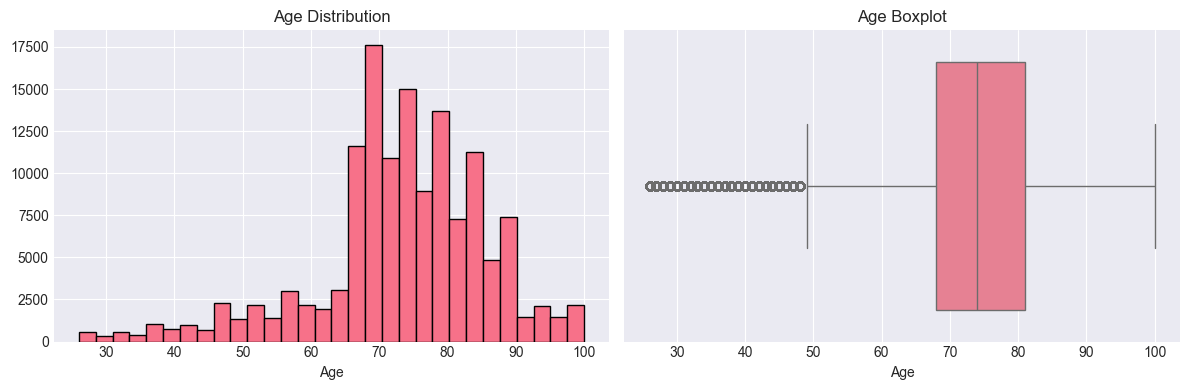


=== GENDER DISTRIBUTION ===
Gender
Female    79106
Male      59450
Name: count, dtype: int64


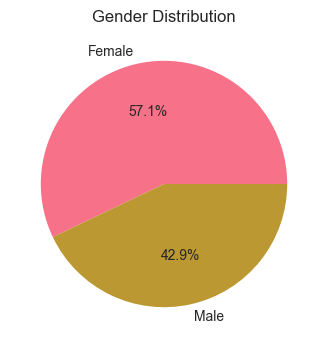


=== RACE DISTRIBUTION ===
Race
White       117057
Black        13538
Other         5059
Hispanic      2902
Name: count, dtype: int64


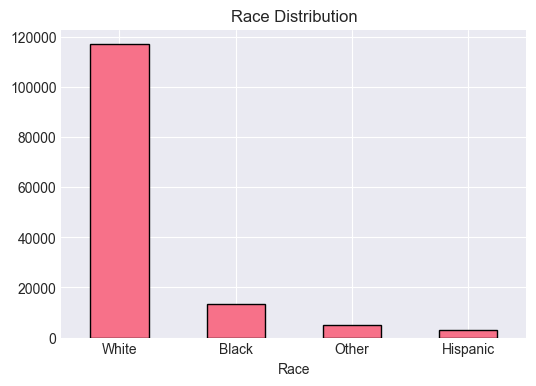


=== TOP STATES ===
State
5     12052
10     9771
45     8780
33     8443
39     6055
14     5923
36     5366
23     5293
34     4629
31     4124
Name: count, dtype: int64


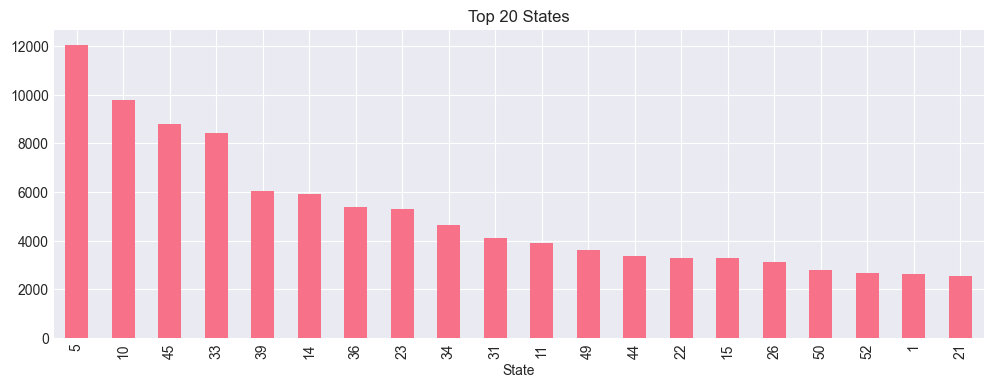


=== CHRONIC CONDITIONS PREVALENCE ===
ChronicCond_IschemicHeart         67.59
ChronicCond_Diabetes              60.19
ChronicCond_Heartfailure          49.37
ChronicCond_Depression            35.55
ChronicCond_Alzheimer             33.22
ChronicCond_KidneyDisease         31.24
ChronicCond_Osteoporasis          27.47
ChronicCond_rheumatoidarthritis   25.68
ChronicCond_ObstrPulmonary        23.72
ChronicCond_Cancer                12.00
ChronicCond_stroke                 7.91
RenalDiseaseIndicator              0.00
dtype: float64


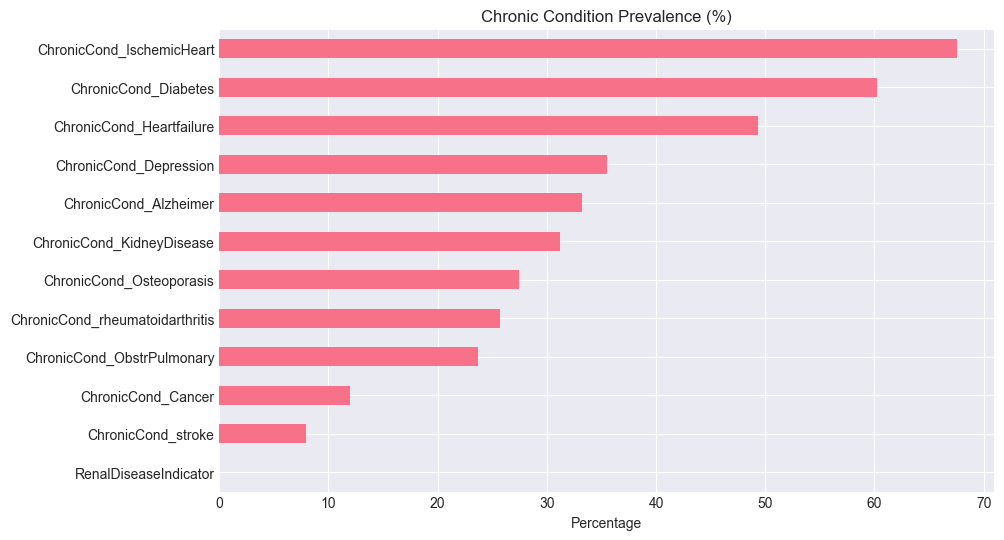

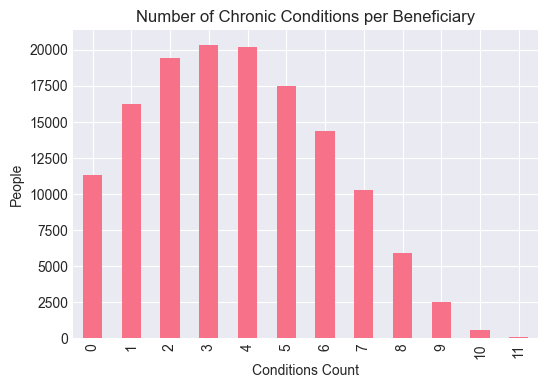


=== MORTALITY ===
DOD
False    137135
True       1421
Name: count, dtype: int64

=== REIMBURSEMENT SUMMARY ===

IPAnnualReimbursementAmt
count   138556.00
mean      3660.35
std       9568.62
min      -8000.00
25%          0.00
50%          0.00
75%       2280.00
max     161470.00
Name: IPAnnualReimbursementAmt, dtype: float64

IPAnnualDeductibleAmt
count   138556.00
mean       399.85
std        956.18
min          0.00
25%          0.00
50%          0.00
75%       1068.00
max      38272.00
Name: IPAnnualDeductibleAmt, dtype: float64

OPAnnualReimbursementAmt
count   138556.00
mean      1298.22
std       2493.90
min        -70.00
25%        170.00
50%        570.00
75%       1500.00
max     102960.00
Name: OPAnnualReimbursementAmt, dtype: float64

OPAnnualDeductibleAmt
count   138556.00
mean       377.72
std        645.53
min          0.00
25%         40.00
50%        170.00
75%        460.00
max      13840.00
Name: OPAnnualDeductibleAmt, dtype: float64


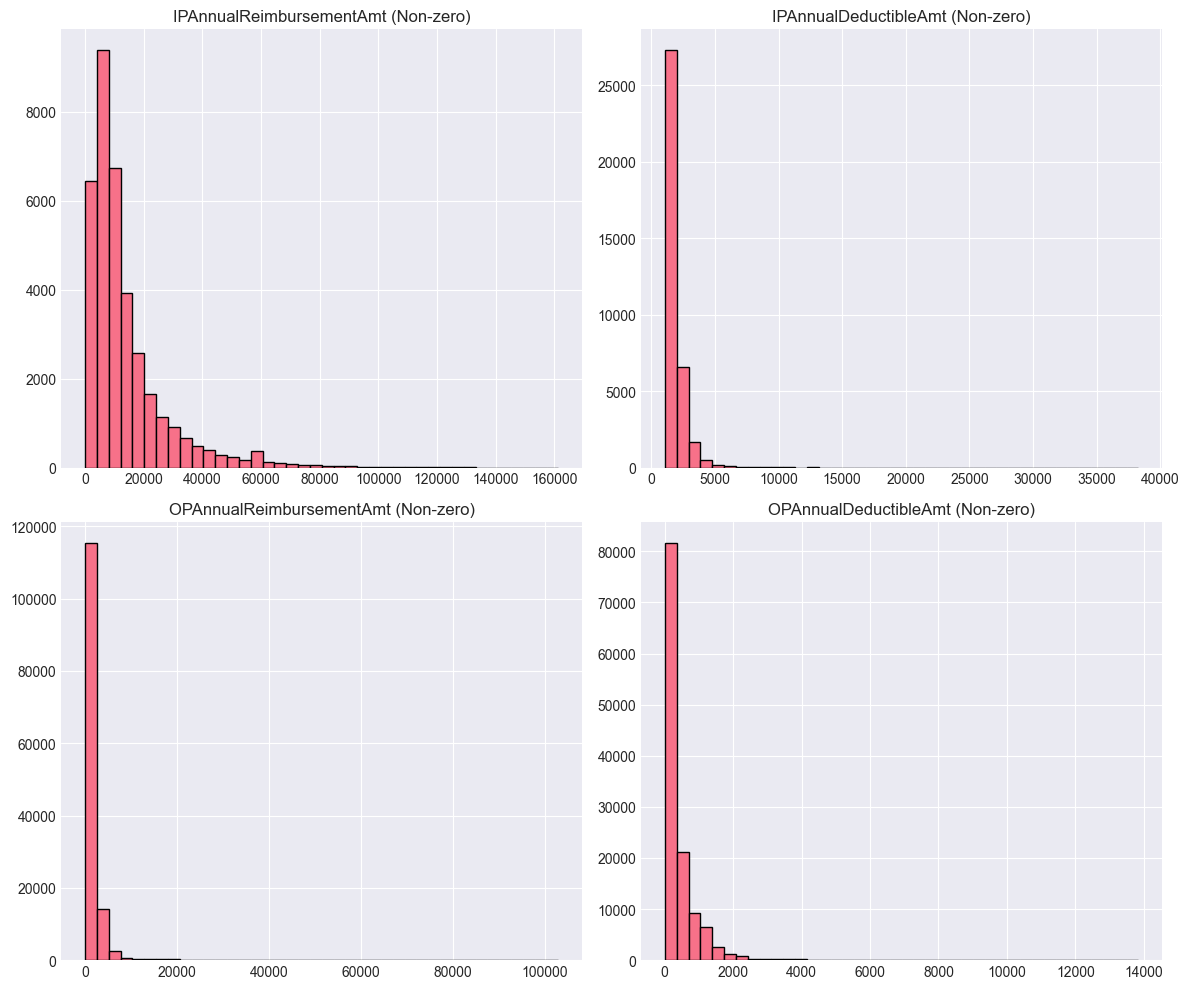


=== OUTLIER SUMMARY (IQR) ===
Age: 7655 outliers
NumChronic: 655 outliers
IPAnnualReimbursementAmt: 26044 outliers
IPAnnualDeductibleAmt: 2717 outliers
OPAnnualReimbursementAmt: 11612 outliers
OPAnnualDeductibleAmt: 12020 outliers

=== EDA COMPLETE ===


In [6]:
# ============================================================
# SIMPLE BENEFICIARY EXPLORATORY DATA ANALYSIS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

beneficiary = beneficiary_df.copy()
beneficiary['DOB'] = pd.to_datetime(beneficiary['DOB'])
reference_date = pd.to_datetime('2009-12-01')
beneficiary['Age'] = ((reference_date - beneficiary['DOB']).dt.days / 365.25).astype(int)

print("\n=== AGE SUMMARY ===")
print(beneficiary['Age'].describe())

# ---------------- FIGURE 1: AGE DISTRIBUTION ----------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(beneficiary['Age'], bins=30, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")

plt.subplot(1,2,2)
sns.boxplot(x=beneficiary['Age'])
plt.title("Age Boxplot")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------

print("\n=== GENDER DISTRIBUTION ===")
gender_map = {1: "Male", 2: "Female"}
print(beneficiary['Gender'].map(gender_map).value_counts())

# ---------------- FIGURE 2: GENDER PIE ----------------
plt.figure(figsize=(4,4))
beneficiary['Gender'].map(gender_map).value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()

# ------------------------------------------------------------

print("\n=== RACE DISTRIBUTION ===")
race_map = {1: 'White', 2: 'Black', 3: 'Other', 5: 'Hispanic'}
print(beneficiary['Race'].map(race_map).value_counts())

# ---------------- FIGURE 3: RACE BAR ----------------
plt.figure(figsize=(6,4))
beneficiary['Race'].map(race_map).value_counts().plot(kind='bar', edgecolor='black')
plt.title("Race Distribution")
plt.xticks(rotation=0)
plt.show()

# ------------------------------------------------------------

print("\n=== TOP STATES ===")
print(beneficiary['State'].value_counts().head(10))

# ---------------- FIGURE 4: STATE BAR ----------------
plt.figure(figsize=(12,4))
beneficiary['State'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 States")
plt.show()

# ------------------------------------------------------------

chronic_cols = [c for c in beneficiary.columns if "ChronicCond" in c or "RenalDiseaseIndicator" in c]

print("\n=== CHRONIC CONDITIONS PREVALENCE ===")
chronic_pct = beneficiary[chronic_cols].eq(1).mean()*100
print(chronic_pct.sort_values(ascending=False))

# ---------------- FIGURE 5: CHRONIC CONDITIONS ----------------
plt.figure(figsize=(10,6))
chronic_pct.sort_values().plot(kind='barh')
plt.title("Chronic Condition Prevalence (%)")
plt.xlabel("Percentage")
plt.show()

# Count conditions per beneficiary
beneficiary['NumChronic'] = beneficiary[chronic_cols].eq(1).sum(axis=1)

# ---------------- FIGURE 6: NUMBER OF CONDITIONS ----------------
plt.figure(figsize=(6,4))
beneficiary['NumChronic'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Chronic Conditions per Beneficiary")
plt.xlabel("Conditions Count")
plt.ylabel("People")
plt.show()

# ------------------------------------------------------------

print("\n=== MORTALITY ===")
print(beneficiary['DOD'].notna().value_counts())

# ------------------------------------------------------------

reimb_cols = [
    'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 
    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt'
]

print("\n=== REIMBURSEMENT SUMMARY ===")
for col in reimb_cols:
    print(f"\n{col}")
    print(beneficiary[col].describe())

# ---------------- FIGURE 7: REIMBURSEMENT HISTOGRAMS ----------------
plt.figure(figsize=(12,10))
for i, col in enumerate(reimb_cols):
    plt.subplot(2,2,i+1)
    nonzero = beneficiary[beneficiary[col] > 0][col]
    plt.hist(nonzero, bins=40, edgecolor='black')
    plt.title(f"{col} (Non-zero)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------

print("\n=== OUTLIER SUMMARY (IQR) ===")
for col in ['Age', 'NumChronic'] + reimb_cols:
    Q1, Q3 = beneficiary[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((beneficiary[col] < lower) | (beneficiary[col] > upper)).sum()
    print(f"{col}: {outliers} outliers")

print("\n=== EDA COMPLETE ===")


### 4.2 Claims Analysis
Analyze claim patterns, amounts, durations, and temporal trends across inpatient and outpatient claims.

CLAIMS EXPLORATORY DATA ANALYSIS
Total Inpatient Claims: 40,474
Total Outpatient Claims: 517,737
Inpatient/Outpatient Ratio: 1:12.8

1. CLAIM AMOUNTS DISTRIBUTION

--- INPATIENT CLAIMS ---
InscClaimAmtReimbursed:
  Mean: $10,087.88
  Median: $7,000.00
  Std Dev: $10,303.10
  Min: $0.00
  Max: $125,000.00
  25th percentile: $4,000.00
  50th percentile: $7,000.00
  75th percentile: $12,000.00
  90th percentile: $20,000.00
  95th percentile: $30,000.00
  99th percentile: $57,000.00

--- OUTPATIENT CLAIMS ---
InscClaimAmtReimbursed:
  Mean: $286.33
  Median: $80.00
  Std Dev: $694.03
  Min: $0.00
  Max: $102,500.00


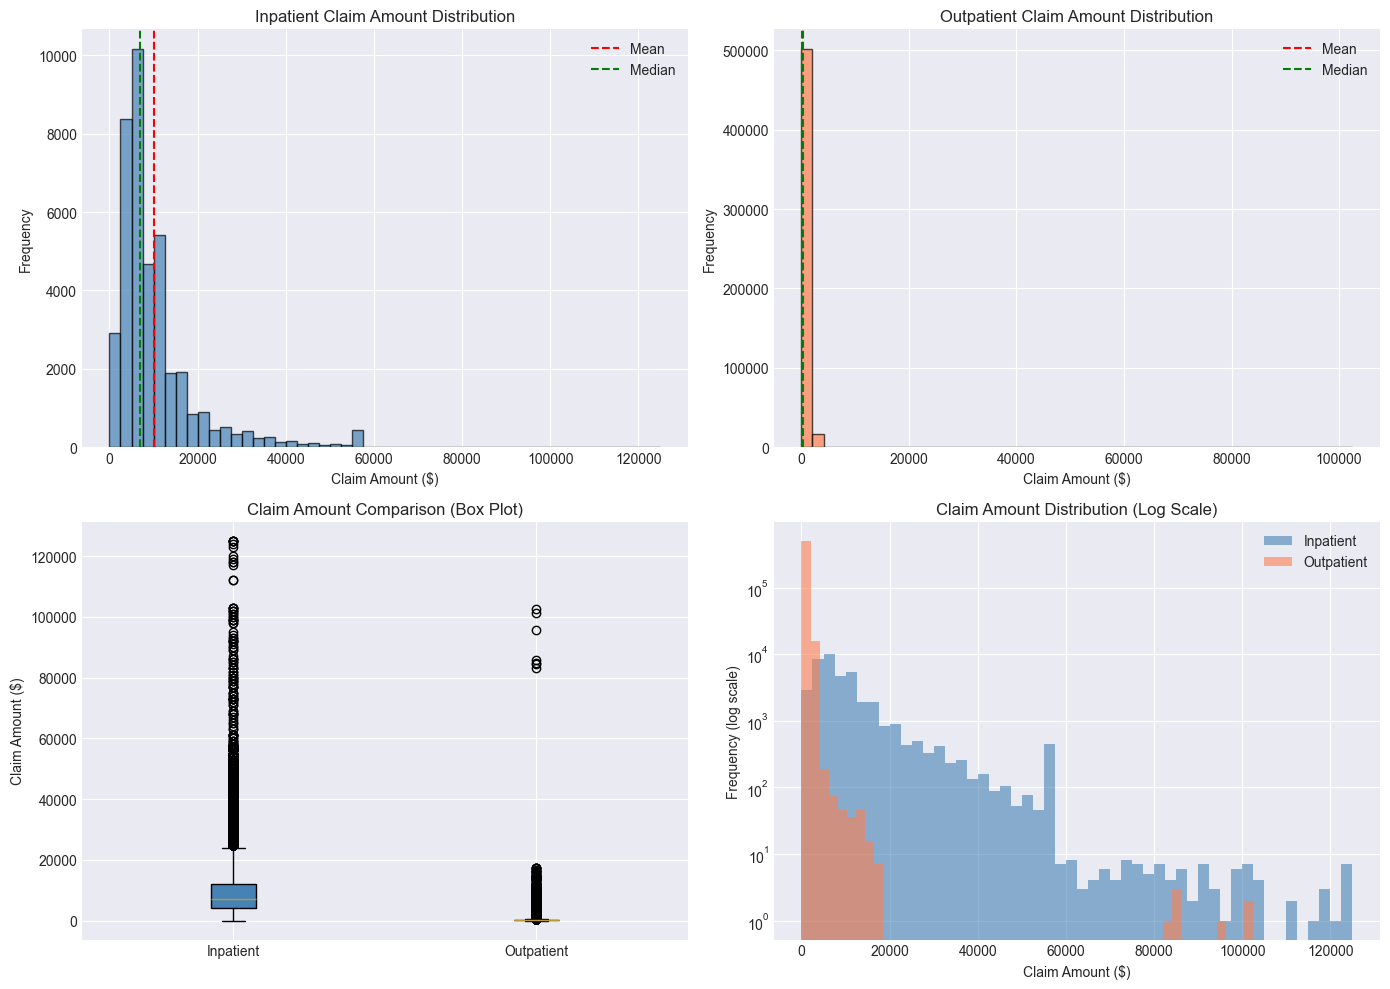


2. CLAIM DURATION ANALYSIS (Inpatient)
Length of Stay (LOS) Statistics:
  Mean: 5.7 days
  Median: 4.0 days
  Std Dev: 5.6 days
  Min: 0 days
  Max: 35 days

  LOS Outliers: 2,792 (6.90%)


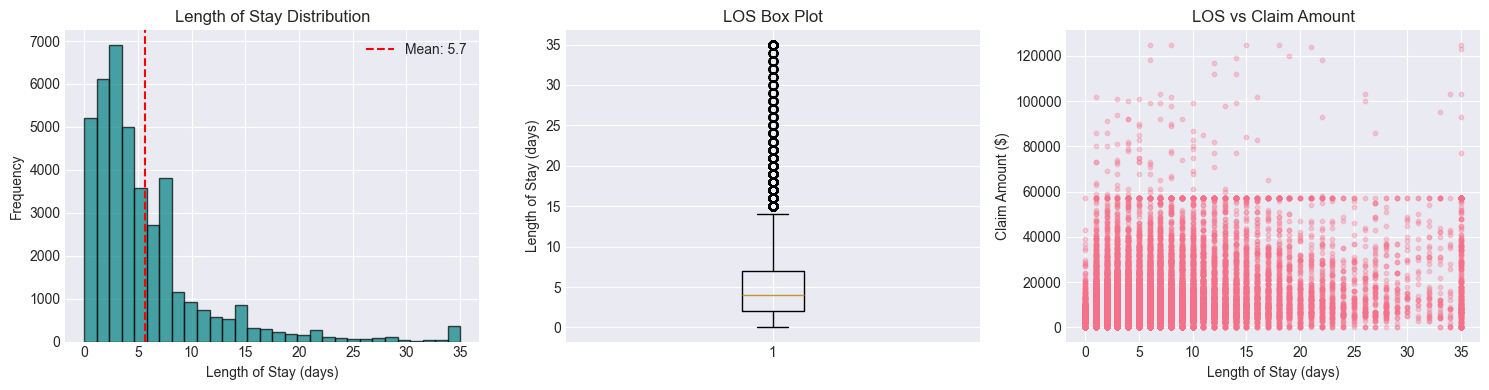


Correlation between LOS and Claim Amount: 0.322

3. TEMPORAL PATTERNS
Inpatient Claims by Month:
  Month 1: 3,731
  Month 2: 3,375
  Month 3: 3,587
  Month 4: 3,427
  Month 5: 3,569
  Month 6: 3,467
  Month 7: 3,371
  Month 8: 3,329
  Month 9: 3,238
  Month 10: 3,232
  Month 11: 3,020
  Month 12: 3,128

Claims by Day of Week:
  Mon: IP=5,836, OP=74,089
  Tue: IP=5,856, OP=73,610
  Wed: IP=5,760, OP=73,785
  Thu: IP=5,806, OP=74,872
  Fri: IP=5,659, OP=73,625
  Sat: IP=5,723, OP=74,081
  Sun: IP=5,834, OP=73,675
Inpatient Claims by Month:
  Month 1: 3,731
  Month 2: 3,375
  Month 3: 3,587
  Month 4: 3,427
  Month 5: 3,569
  Month 6: 3,467
  Month 7: 3,371
  Month 8: 3,329
  Month 9: 3,238
  Month 10: 3,232
  Month 11: 3,020
  Month 12: 3,128

Claims by Day of Week:
  Mon: IP=5,836, OP=74,089
  Tue: IP=5,856, OP=73,610
  Wed: IP=5,760, OP=73,785
  Thu: IP=5,806, OP=74,872
  Fri: IP=5,659, OP=73,625
  Sat: IP=5,723, OP=74,081
  Sun: IP=5,834, OP=73,675


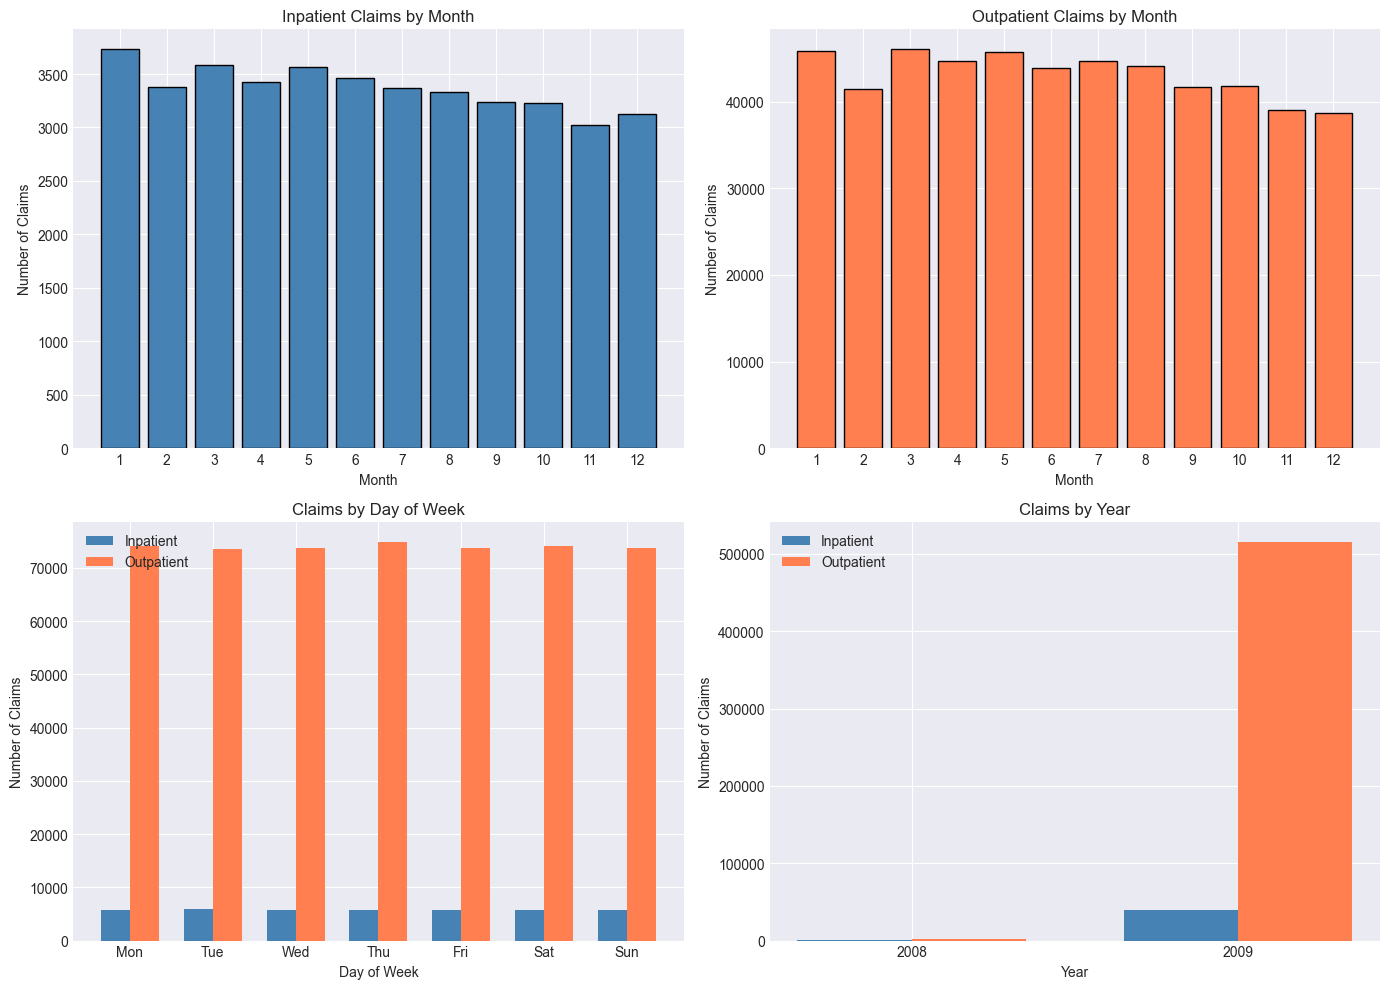


4. DIAGNOSIS AND PROCEDURE PATTERNS

Diagnosis Code Columns: 10
Procedure Code Columns: 6

Number of Diagnoses per Claim (Inpatient):
  Mean: 8.09
  Median: 9.0
  Max: 10

Number of Diagnoses per Claim (Outpatient):
  Mean: 2.61
  Median: 2.0
  Max: 10

Number of Procedures per Claim (Inpatient):
  Mean: 0.73
  Median: 1.0
  Max: 5
  Claims with procedures: 23,148 (57.2%)

Top 10 Primary Diagnosis Codes (Inpatient):
  486: 1,499
  V5789: 1,158
  41401: 1,088
  49121: 974
  0389: 945
  5990: 844
  4280: 825
  42731: 760
  41071: 718
  71536: 713

Number of Diagnoses per Claim (Inpatient):
  Mean: 8.09
  Median: 9.0
  Max: 10

Number of Diagnoses per Claim (Outpatient):
  Mean: 2.61
  Median: 2.0
  Max: 10

Number of Procedures per Claim (Inpatient):
  Mean: 0.73
  Median: 1.0
  Max: 5
  Claims with procedures: 23,148 (57.2%)

Top 10 Primary Diagnosis Codes (Inpatient):
  486: 1,499
  V5789: 1,158
  41401: 1,088
  49121: 974
  0389: 945
  5990: 844
  4280: 825
  42731: 760
  41071: 718


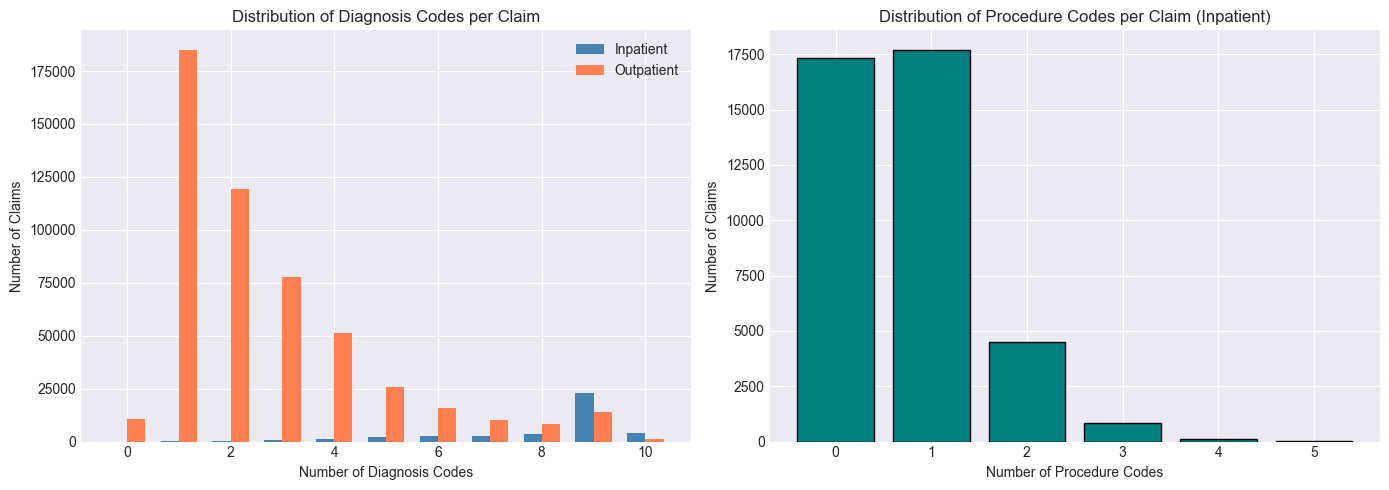


5. PHYSICIAN INVOLVEMENT
Inpatient - AttendingPhysician: 40,362 (99.7%)
Outpatient - AttendingPhysician: 516,341 (99.7%)
Inpatient - OperatingPhysician: 23,830 (58.9%)
Outpatient - OperatingPhysician: 90,617 (17.5%)
Inpatient - OtherPhysician: 4,690 (11.6%)
Outpatient - OtherPhysician: 195,046 (37.7%)

Unique AttendingPhysician: IP=11,604, OP=74,109

Unique OperatingPhysician: IP=8,287, OP=28,532

Unique OtherPhysician: IP=2,877, OP=44,388

6. DEDUCTIBLE ANALYSIS

Inpatient Deductible:
  Mean: $1,068.00
  Median: $1,068.00
  Max: $1,068.00
  Zero deductibles: 0 (0.0%)

Outpatient Deductible:
  Mean: $2.78
  Median: $0.00
  Max: $897.00
  Zero deductibles: 496,701 (95.9%)

7. CLAIM AMOUNT OUTLIER DETECTION

Using IQR method:
  Inpatient Claim Amount Outliers: 2,966 (7.33%)
    Outlier range: $25,000.00 - $125,000.00
  Outpatient Claim Amount Outliers: 78,375 (15.14%)
    Outlier range: $450.00 - $102,500.00

CLAIMS EDA COMPLETE
  Inpatient Claim Amount Outliers: 2,966 (7.33%)
    Outli

In [7]:
# ============================================================
# CLAIMS EXPLORATORY DATA ANALYSIS
# ============================================================
# Patterns, distributions, and outliers in claims data

print("=" * 70)
print("CLAIMS EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Combine inpatient and outpatient for overall claims analysis
inpatient_claims = inpatient_df.copy()
inpatient_claims['ClaimType'] = 'Inpatient'
outpatient_claims = outpatient_df.copy()
outpatient_claims['ClaimType'] = 'Outpatient'

print(f"Total Inpatient Claims: {len(inpatient_claims):,}")
print(f"Total Outpatient Claims: {len(outpatient_claims):,}")
print(f"Inpatient/Outpatient Ratio: 1:{len(outpatient_claims)/len(inpatient_claims):.1f}")

# --- 1. CLAIM AMOUNTS DISTRIBUTION ---
print("\n" + "="*50)
print("1. CLAIM AMOUNTS DISTRIBUTION")
print("="*50)

# Inpatient claim amounts
print("\n--- INPATIENT CLAIMS ---")
inpatient_amount_col = 'InscClaimAmtReimbursed'
if inpatient_amount_col in inpatient_claims.columns:
    print(f"{inpatient_amount_col}:")
    print(f"  Mean: ${inpatient_claims[inpatient_amount_col].mean():,.2f}")
    print(f"  Median: ${inpatient_claims[inpatient_amount_col].median():,.2f}")
    print(f"  Std Dev: ${inpatient_claims[inpatient_amount_col].std():,.2f}")
    print(f"  Min: ${inpatient_claims[inpatient_amount_col].min():,.2f}")
    print(f"  Max: ${inpatient_claims[inpatient_amount_col].max():,.2f}")
    
    # Percentiles
    for p in [25, 50, 75, 90, 95, 99]:
        val = inpatient_claims[inpatient_amount_col].quantile(p/100)
        print(f"  {p}th percentile: ${val:,.2f}")

# Outpatient claim amounts
print("\n--- OUTPATIENT CLAIMS ---")
if inpatient_amount_col in outpatient_claims.columns:
    print(f"{inpatient_amount_col}:")
    print(f"  Mean: ${outpatient_claims[inpatient_amount_col].mean():,.2f}")
    print(f"  Median: ${outpatient_claims[inpatient_amount_col].median():,.2f}")
    print(f"  Std Dev: ${outpatient_claims[inpatient_amount_col].std():,.2f}")
    print(f"  Min: ${outpatient_claims[inpatient_amount_col].min():,.2f}")
    print(f"  Max: ${outpatient_claims[inpatient_amount_col].max():,.2f}")

# Visualize claim amount distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inpatient histogram
axes[0, 0].hist(inpatient_claims[inpatient_amount_col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(inpatient_claims[inpatient_amount_col].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].axvline(inpatient_claims[inpatient_amount_col].median(), color='green', linestyle='--', label='Median')
axes[0, 0].set_xlabel('Claim Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Inpatient Claim Amount Distribution')
axes[0, 0].legend()

# Outpatient histogram
axes[0, 1].hist(outpatient_claims[inpatient_amount_col], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(outpatient_claims[inpatient_amount_col].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].axvline(outpatient_claims[inpatient_amount_col].median(), color='green', linestyle='--', label='Median')
axes[0, 1].set_xlabel('Claim Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Outpatient Claim Amount Distribution')
axes[0, 1].legend()

# Box plots comparison
box_data = [inpatient_claims[inpatient_amount_col], outpatient_claims[inpatient_amount_col]]
bp = axes[1, 0].boxplot(box_data, labels=['Inpatient', 'Outpatient'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
axes[1, 0].set_ylabel('Claim Amount ($)')
axes[1, 0].set_title('Claim Amount Comparison (Box Plot)')

# Log scale histogram for better visualization
axes[1, 1].hist(inpatient_claims[inpatient_amount_col], bins=50, alpha=0.6, label='Inpatient', color='steelblue')
axes[1, 1].hist(outpatient_claims[inpatient_amount_col], bins=50, alpha=0.6, label='Outpatient', color='coral')
axes[1, 1].set_xlabel('Claim Amount ($)')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Claim Amount Distribution (Log Scale)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# --- 2. CLAIM DURATION ANALYSIS (Inpatient Only) ---
print("\n" + "="*50)
print("2. CLAIM DURATION ANALYSIS (Inpatient)")
print("="*50)

# Calculate admission duration if dates available
if 'AdmissionDt' in inpatient_claims.columns and 'DischargeDt' in inpatient_claims.columns:
    inpatient_claims['AdmissionDt'] = pd.to_datetime(inpatient_claims['AdmissionDt'])
    inpatient_claims['DischargeDt'] = pd.to_datetime(inpatient_claims['DischargeDt'])
    inpatient_claims['LOS'] = (inpatient_claims['DischargeDt'] - inpatient_claims['AdmissionDt']).dt.days
    
    print("Length of Stay (LOS) Statistics:")
    print(f"  Mean: {inpatient_claims['LOS'].mean():.1f} days")
    print(f"  Median: {inpatient_claims['LOS'].median():.1f} days")
    print(f"  Std Dev: {inpatient_claims['LOS'].std():.1f} days")
    print(f"  Min: {inpatient_claims['LOS'].min()} days")
    print(f"  Max: {inpatient_claims['LOS'].max()} days")
    
    # LOS outliers
    Q1 = inpatient_claims['LOS'].quantile(0.25)
    Q3 = inpatient_claims['LOS'].quantile(0.75)
    IQR = Q3 - Q1
    los_outliers = inpatient_claims[(inpatient_claims['LOS'] < Q1 - 1.5*IQR) | (inpatient_claims['LOS'] > Q3 + 1.5*IQR)]
    print(f"\n  LOS Outliers: {len(los_outliers):,} ({100*len(los_outliers)/len(inpatient_claims):.2f}%)")
    
    # LOS distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(inpatient_claims['LOS'], bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[0].axvline(inpatient_claims['LOS'].mean(), color='red', linestyle='--', label=f'Mean: {inpatient_claims["LOS"].mean():.1f}')
    axes[0].set_xlabel('Length of Stay (days)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Length of Stay Distribution')
    axes[0].legend()
    
    axes[1].boxplot(inpatient_claims['LOS'])
    axes[1].set_ylabel('Length of Stay (days)')
    axes[1].set_title('LOS Box Plot')
    
    # LOS vs Claim Amount
    axes[2].scatter(inpatient_claims['LOS'], inpatient_claims[inpatient_amount_col], alpha=0.3, s=10)
    axes[2].set_xlabel('Length of Stay (days)')
    axes[2].set_ylabel('Claim Amount ($)')
    axes[2].set_title('LOS vs Claim Amount')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation
    corr = inpatient_claims['LOS'].corr(inpatient_claims[inpatient_amount_col])
    print(f"\nCorrelation between LOS and Claim Amount: {corr:.3f}")

# --- 3. TEMPORAL PATTERNS ---
print("\n" + "="*50)
print("3. TEMPORAL PATTERNS")
print("="*50)

# Claims by month
if 'ClaimStartDt' in inpatient_claims.columns:
    inpatient_claims['ClaimStartDt'] = pd.to_datetime(inpatient_claims['ClaimStartDt'])
    inpatient_claims['ClaimMonth'] = inpatient_claims['ClaimStartDt'].dt.month
    inpatient_claims['ClaimYear'] = inpatient_claims['ClaimStartDt'].dt.year
    inpatient_claims['ClaimDayOfWeek'] = inpatient_claims['ClaimStartDt'].dt.dayofweek

if 'ClaimStartDt' in outpatient_claims.columns:
    outpatient_claims['ClaimStartDt'] = pd.to_datetime(outpatient_claims['ClaimStartDt'])
    outpatient_claims['ClaimMonth'] = outpatient_claims['ClaimStartDt'].dt.month
    outpatient_claims['ClaimYear'] = outpatient_claims['ClaimStartDt'].dt.year
    outpatient_claims['ClaimDayOfWeek'] = outpatient_claims['ClaimStartDt'].dt.dayofweek

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly trend - Inpatient
if 'ClaimMonth' in inpatient_claims.columns:
    monthly_ip = inpatient_claims.groupby('ClaimMonth').size()
    axes[0, 0].bar(monthly_ip.index, monthly_ip.values, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Number of Claims')
    axes[0, 0].set_title('Inpatient Claims by Month')
    axes[0, 0].set_xticks(range(1, 13))
    
    print("Inpatient Claims by Month:")
    for month, count in monthly_ip.items():
        print(f"  Month {month}: {count:,}")

# Monthly trend - Outpatient
if 'ClaimMonth' in outpatient_claims.columns:
    monthly_op = outpatient_claims.groupby('ClaimMonth').size()
    axes[0, 1].bar(monthly_op.index, monthly_op.values, color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Number of Claims')
    axes[0, 1].set_title('Outpatient Claims by Month')
    axes[0, 1].set_xticks(range(1, 13))

# Day of week pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
if 'ClaimDayOfWeek' in inpatient_claims.columns:
    dow_ip = inpatient_claims.groupby('ClaimDayOfWeek').size()
    dow_op = outpatient_claims.groupby('ClaimDayOfWeek').size()
    
    x = np.arange(7)
    width = 0.35
    
    axes[1, 0].bar(x - width/2, [dow_ip.get(i, 0) for i in range(7)], width, label='Inpatient', color='steelblue')
    axes[1, 0].bar(x + width/2, [dow_op.get(i, 0) for i in range(7)], width, label='Outpatient', color='coral')
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_ylabel('Number of Claims')
    axes[1, 0].set_title('Claims by Day of Week')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(day_names)
    axes[1, 0].legend()
    
    print("\nClaims by Day of Week:")
    for i, day in enumerate(day_names):
        print(f"  {day}: IP={dow_ip.get(i, 0):,}, OP={dow_op.get(i, 0):,}")

# Yearly trend
if 'ClaimYear' in inpatient_claims.columns:
    yearly_ip = inpatient_claims.groupby('ClaimYear').size()
    yearly_op = outpatient_claims.groupby('ClaimYear').size()
    
    all_years = sorted(set(yearly_ip.index) | set(yearly_op.index))
    x = np.arange(len(all_years))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, [yearly_ip.get(y, 0) for y in all_years], width, label='Inpatient', color='steelblue')
    axes[1, 1].bar(x + width/2, [yearly_op.get(y, 0) for y in all_years], width, label='Outpatient', color='coral')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Number of Claims')
    axes[1, 1].set_title('Claims by Year')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(all_years)
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# --- 4. DIAGNOSIS AND PROCEDURE PATTERNS ---
print("\n" + "="*50)
print("4. DIAGNOSIS AND PROCEDURE PATTERNS")
print("="*50)

# Diagnosis code columns
diag_cols = [col for col in inpatient_claims.columns if 'ClmDiagnosisCode' in col]
proc_cols = [col for col in inpatient_claims.columns if 'ClmProcedureCode' in col]

print(f"\nDiagnosis Code Columns: {len(diag_cols)}")
print(f"Procedure Code Columns: {len(proc_cols)}")

# Number of diagnosis codes per claim
if diag_cols:
    inpatient_claims['NumDiagnoses'] = inpatient_claims[diag_cols].notna().sum(axis=1)
    outpatient_claims['NumDiagnoses'] = outpatient_claims[[c for c in diag_cols if c in outpatient_claims.columns]].notna().sum(axis=1)
    
    print("\nNumber of Diagnoses per Claim (Inpatient):")
    print(f"  Mean: {inpatient_claims['NumDiagnoses'].mean():.2f}")
    print(f"  Median: {inpatient_claims['NumDiagnoses'].median():.1f}")
    print(f"  Max: {inpatient_claims['NumDiagnoses'].max()}")
    
    print("\nNumber of Diagnoses per Claim (Outpatient):")
    print(f"  Mean: {outpatient_claims['NumDiagnoses'].mean():.2f}")
    print(f"  Median: {outpatient_claims['NumDiagnoses'].median():.1f}")
    print(f"  Max: {outpatient_claims['NumDiagnoses'].max()}")

# Number of procedures per claim (inpatient only typically)
if proc_cols:
    inpatient_claims['NumProcedures'] = inpatient_claims[proc_cols].notna().sum(axis=1)
    
    print("\nNumber of Procedures per Claim (Inpatient):")
    print(f"  Mean: {inpatient_claims['NumProcedures'].mean():.2f}")
    print(f"  Median: {inpatient_claims['NumProcedures'].median():.1f}")
    print(f"  Max: {inpatient_claims['NumProcedures'].max()}")
    print(f"  Claims with procedures: {(inpatient_claims['NumProcedures'] > 0).sum():,} ({100*(inpatient_claims['NumProcedures'] > 0).sum()/len(inpatient_claims):.1f}%)")

# Top diagnosis codes
if diag_cols and len(diag_cols) > 0:
    print("\nTop 10 Primary Diagnosis Codes (Inpatient):")
    primary_diag = inpatient_claims[diag_cols[0]].value_counts().head(10)
    for code, count in primary_diag.items():
        print(f"  {code}: {count:,}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'NumDiagnoses' in inpatient_claims.columns:
    diag_dist_ip = inpatient_claims['NumDiagnoses'].value_counts().sort_index()
    diag_dist_op = outpatient_claims['NumDiagnoses'].value_counts().sort_index()
    
    x = np.arange(max(diag_dist_ip.index.max(), diag_dist_op.index.max()) + 1)
    width = 0.35
    
    axes[0].bar(x - width/2, [diag_dist_ip.get(i, 0) for i in x], width, label='Inpatient', color='steelblue')
    axes[0].bar(x + width/2, [diag_dist_op.get(i, 0) for i in x], width, label='Outpatient', color='coral')
    axes[0].set_xlabel('Number of Diagnosis Codes')
    axes[0].set_ylabel('Number of Claims')
    axes[0].set_title('Distribution of Diagnosis Codes per Claim')
    axes[0].legend()

if 'NumProcedures' in inpatient_claims.columns:
    proc_dist = inpatient_claims['NumProcedures'].value_counts().sort_index()
    axes[1].bar(proc_dist.index, proc_dist.values, color='teal', edgecolor='black')
    axes[1].set_xlabel('Number of Procedure Codes')
    axes[1].set_ylabel('Number of Claims')
    axes[1].set_title('Distribution of Procedure Codes per Claim (Inpatient)')

plt.tight_layout()
plt.show()

# --- 5. PHYSICIAN INVOLVEMENT ---
print("\n" + "="*50)
print("5. PHYSICIAN INVOLVEMENT")
print("="*50)

physician_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
for col in physician_cols:
    if col in inpatient_claims.columns:
        has_phys = inpatient_claims[col].notna().sum()
        print(f"Inpatient - {col}: {has_phys:,} ({100*has_phys/len(inpatient_claims):.1f}%)")
    if col in outpatient_claims.columns:
        has_phys = outpatient_claims[col].notna().sum()
        print(f"Outpatient - {col}: {has_phys:,} ({100*has_phys/len(outpatient_claims):.1f}%)")

# Unique physicians
for col in physician_cols:
    if col in inpatient_claims.columns:
        unique_ip = inpatient_claims[col].nunique()
        unique_op = outpatient_claims[col].nunique() if col in outpatient_claims.columns else 0
        print(f"\nUnique {col}: IP={unique_ip:,}, OP={unique_op:,}")

# --- 6. DEDUCTIBLE ANALYSIS ---
print("\n" + "="*50)
print("6. DEDUCTIBLE ANALYSIS")
print("="*50)

ded_col = 'DeductibleAmtPaid'
if ded_col in inpatient_claims.columns:
    print("\nInpatient Deductible:")
    print(f"  Mean: ${inpatient_claims[ded_col].mean():,.2f}")
    print(f"  Median: ${inpatient_claims[ded_col].median():,.2f}")
    print(f"  Max: ${inpatient_claims[ded_col].max():,.2f}")
    print(f"  Zero deductibles: {(inpatient_claims[ded_col] == 0).sum():,} ({100*(inpatient_claims[ded_col] == 0).sum()/len(inpatient_claims):.1f}%)")

if ded_col in outpatient_claims.columns:
    print("\nOutpatient Deductible:")
    print(f"  Mean: ${outpatient_claims[ded_col].mean():,.2f}")
    print(f"  Median: ${outpatient_claims[ded_col].median():,.2f}")
    print(f"  Max: ${outpatient_claims[ded_col].max():,.2f}")
    print(f"  Zero deductibles: {(outpatient_claims[ded_col] == 0).sum():,} ({100*(outpatient_claims[ded_col] == 0).sum()/len(outpatient_claims):.1f}%)")

# --- 7. OUTLIER SUMMARY ---
print("\n" + "="*50)
print("7. CLAIM AMOUNT OUTLIER DETECTION")
print("="*50)

print("\nUsing IQR method:")
for claim_type, df in [('Inpatient', inpatient_claims), ('Outpatient', outpatient_claims)]:
    if inpatient_amount_col in df.columns:
        Q1 = df[inpatient_amount_col].quantile(0.25)
        Q3 = df[inpatient_amount_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[inpatient_amount_col] < lower) | (df[inpatient_amount_col] > upper)]
        print(f"  {claim_type} Claim Amount Outliers: {len(outliers):,} ({100*len(outliers)/len(df):.2f}%)")
        if len(outliers) > 0:
            print(f"    Outlier range: ${outliers[inpatient_amount_col].min():,.2f} - ${outliers[inpatient_amount_col].max():,.2f}")

print("\n" + "="*70)
print("CLAIMS EDA COMPLETE")
print("="*70)

### 4.3 Provider Analysis
Analyze provider patterns, claim volumes, reimbursements, and identify potential fraud indicators at the provider level.

PROVIDER EXPLORATORY DATA ANALYSIS (Simplified)
Total Unique Providers: 5,410
IP Only: 398
OP Only: 3,318
In Both: 1,694
Fraudulent Providers: 506

Claim Volume Summary:
mean    103.18
50%      31.00
max    8240.00
Name: Total_Claims, dtype: float64


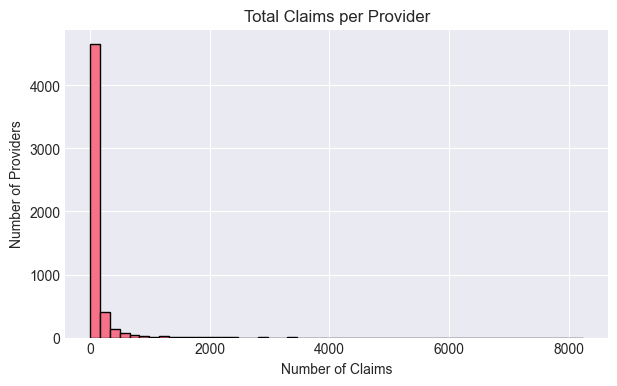


Reimbursement Summary:
mean    102873.04
50%      19805.00
max    5996050.00
Name: Total_Reimb, dtype: float64


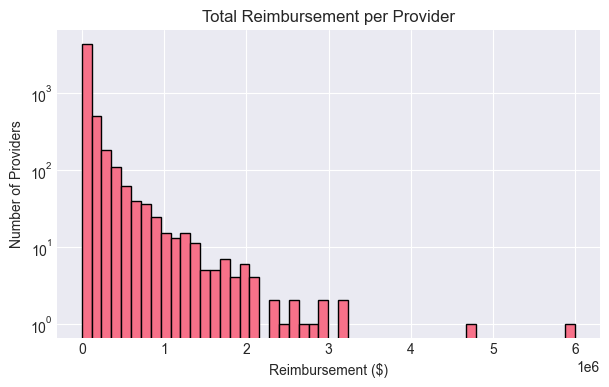


Fraud vs Non-Fraud (Mean Values):
Total_Claims: Fraud=420.5  | Non-Fraud=70.4
Total_Reimb: Fraud=584350.0  | Non-Fraud=53193.7


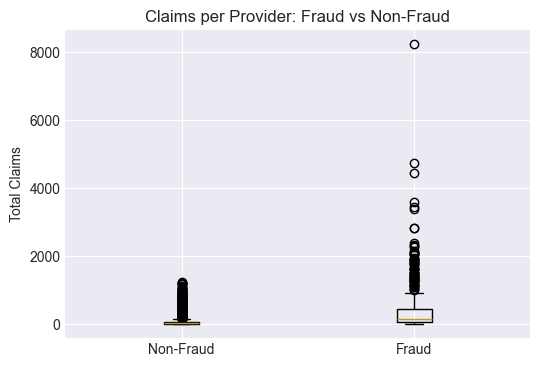


Provider Claim Volume Outliers: 622
PROVIDER EDA (Simplified Version) COMPLETE


In [8]:
# ============================================================
# SIMPLIFIED PROVIDER EXPLORATORY DATA ANALYSIS
# ============================================================

print("="*70)
print("PROVIDER EXPLORATORY DATA ANALYSIS (Simplified)")
print("="*70)

# ------------------------------------------------------------
# 1. PROVIDER OVERVIEW
# ------------------------------------------------------------
ip_providers = inpatient_df['Provider'].unique()
op_providers = outpatient_df['Provider'].unique()
all_providers = set(ip_providers) | set(op_providers)

print(f"Total Unique Providers: {len(all_providers):,}")
print(f"IP Only: {len(set(ip_providers) - set(op_providers)):,}")
print(f"OP Only: {len(set(op_providers) - set(ip_providers)):,}")
print(f"In Both: {len(set(ip_providers) & set(op_providers)):,}")

fraud_count = (labels_df['PotentialFraud'] == 'Yes').sum()
print(f"Fraudulent Providers: {fraud_count:,}")

# ------------------------------------------------------------
# 2. CLAIM VOLUME SUMMARY
# ------------------------------------------------------------
ip_claims = inpatient_df.groupby('Provider').size().reset_index(name='IP_Claims')
op_claims = outpatient_df.groupby('Provider').size().reset_index(name='OP_Claims')

provider_stats = ip_claims.merge(op_claims, on='Provider', how='outer').fillna(0)
provider_stats['Total_Claims'] = provider_stats['IP_Claims'] + provider_stats['OP_Claims']

print("\nClaim Volume Summary:")
print(provider_stats['Total_Claims'].describe()[['mean','50%','max']])

# --- Important Plot: Claims per Provider ---
plt.figure(figsize=(7,4))
plt.hist(provider_stats['Total_Claims'], bins=50, edgecolor='black')
plt.title("Total Claims per Provider")
plt.xlabel("Number of Claims")
plt.ylabel("Number of Providers")
plt.show()

# ------------------------------------------------------------
# 3. REIMBURSEMENT SUMMARY
# ------------------------------------------------------------
ip_re = inpatient_df.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index(name='IP_Reimb')
op_re = outpatient_df.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index(name='OP_Reimb')

provider_stats = provider_stats.merge(ip_re, on='Provider', how='left').merge(op_re, on='Provider', how='left').fillna(0)
provider_stats['Total_Reimb'] = provider_stats['IP_Reimb'] + provider_stats['OP_Reimb']

print("\nReimbursement Summary:")
print(provider_stats['Total_Reimb'].describe()[['mean','50%','max']])

# --- Important Plot: Total Reimbursement ---
plt.figure(figsize=(7,4))
plt.hist(provider_stats[provider_stats['Total_Reimb']>0]['Total_Reimb'], bins=50, edgecolor='black')
plt.title("Total Reimbursement per Provider")
plt.xlabel("Reimbursement ($)")
plt.ylabel("Number of Providers")
plt.yscale('log')
plt.show()

# ------------------------------------------------------------
# 4. FRAUD COMPARISON
# ------------------------------------------------------------
provider_fraud = provider_stats.merge(labels_df, on='Provider', how='left')
provider_fraud['IsFraud'] = (provider_fraud['PotentialFraud']=='Yes').astype(int)

fraud = provider_fraud[provider_fraud['IsFraud']==1]
nonfraud = provider_fraud[provider_fraud['IsFraud']==0]

print("\nFraud vs Non-Fraud (Mean Values):")
metrics = ['Total_Claims','Total_Reimb']
for col in metrics:
    print(f"{col}: Fraud={fraud[col].mean():.1f}  | Non-Fraud={nonfraud[col].mean():.1f}")

# --- Important Plot: Claims Comparison ---
plt.figure(figsize=(6,4))
plt.boxplot([nonfraud['Total_Claims'], fraud['Total_Claims']], labels=['Non-Fraud','Fraud'])
plt.title("Claims per Provider: Fraud vs Non-Fraud")
plt.ylabel("Total Claims")
plt.show()

# ------------------------------------------------------------
# 5. OUTLIER PROVIDERS (Claim Count)
# ------------------------------------------------------------
Q1 = provider_stats['Total_Claims'].quantile(0.25)
Q3 = provider_stats['Total_Claims'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR

outliers = provider_stats[provider_stats['Total_Claims'] > upper]
print(f"\nProvider Claim Volume Outliers: {len(outliers)}")

# ------------------------------------------------------------
print("="*70)
print("PROVIDER EDA (Simplified Version) COMPLETE")
print("="*70)


## Clean inpatient

In [9]:
# Clean inpatient - Train
inpatient_df.replace("NA", np.nan, inplace=True)
proc_cols = [c for c in inpatient_df.columns if "ClmProcedureCode" in c]
diag_cols = [c for c in inpatient_df.columns if "ClmDiagnosisCode" in c]
phys_cols = ["AttendingPhysician", "OperatingPhysician", "OtherPhysician"]
deduct_cols = [c for c in inpatient_df.columns if "DeductibleAmtPaid" in c]
inpatient_df[deduct_cols] = inpatient_df[deduct_cols].replace('', 0)
inpatient_df[deduct_cols] = inpatient_df[deduct_cols].replace(np.nan,0)

inpatient_df["proc_count"] = inpatient_df[proc_cols].notna().sum(axis=1)
inpatient_df["diag_count"] = inpatient_df[diag_cols].notna().sum(axis=1)

# Physician features
inpatient_df["HasAttendingPhysician"] = inpatient_df["AttendingPhysician"].notna().astype(int)
inpatient_df["HasOperatingPhysician"] = inpatient_df["OperatingPhysician"].notna().astype(int)
inpatient_df["HasOtherPhysician"] = inpatient_df["OtherPhysician"].notna().astype(int)

# UniquePhysicianCount - count unique non-null physicians
inpatient_df["UniquePhysicianCount"] = inpatient_df[phys_cols].apply(
    lambda row: row.dropna().nunique(), axis=1
)

# SamePhysicianAllRoles - 1 if all non-null physicians are the same, 0 otherwise
def same_physician_all_roles(row):
    non_null = row.dropna()
    if len(non_null) <= 1:
        return 0  # Need at least 2 physicians to compare
    return 1 if non_null.nunique() == 1 else 0

inpatient_df["SamePhysicianAllRoles"] = inpatient_df[phys_cols].apply(same_physician_all_roles, axis=1)

# Drop columns
drop_cols = ["ClmAdmitDiagnosisCode", "OperatingPhysician", "OtherPhysician", "AttendingPhysician",
             "ClmDiagnosisCode_1","ClmDiagnosisCode_2","ClmDiagnosisCode_3","ClmDiagnosisCode_4",
             "ClmDiagnosisCode_5","ClmDiagnosisCode_6","ClmDiagnosisCode_7","ClmDiagnosisCode_8",
             "ClmDiagnosisCode_9","ClmDiagnosisCode_10",
             "ClmProcedureCode_1","ClmProcedureCode_2","ClmProcedureCode_3",
             "ClmProcedureCode_4","ClmProcedureCode_5","ClmProcedureCode_6"]
inpatient_df.drop(columns=[c for c in drop_cols if c in inpatient_df.columns], inplace=True)

# Clean inpatient - Test
test_inpatient_df.replace("NA", np.nan, inplace=True)
test_proc_cols = [c for c in test_inpatient_df.columns if "ClmProcedureCode" in c]
test_diag_cols = [c for c in test_inpatient_df.columns if "ClmDiagnosisCode" in c]
test_phys_cols = ["AttendingPhysician", "OperatingPhysician", "OtherPhysician"]
test_deduct_cols = [c for c in test_inpatient_df.columns if "DeductibleAmtPaid" in c]
test_inpatient_df[test_deduct_cols] = test_inpatient_df[test_deduct_cols].replace('', 0)
test_inpatient_df[test_deduct_cols] = test_inpatient_df[test_deduct_cols].replace(np.nan,0)

test_inpatient_df["proc_count"] = test_inpatient_df[test_proc_cols].notna().sum(axis=1)
test_inpatient_df["diag_count"] = test_inpatient_df[test_diag_cols].notna().sum(axis=1)

# Physician features
test_inpatient_df["HasAttendingPhysician"] = test_inpatient_df["AttendingPhysician"].notna().astype(int)
test_inpatient_df["HasOperatingPhysician"] = test_inpatient_df["OperatingPhysician"].notna().astype(int)
test_inpatient_df["HasOtherPhysician"] = test_inpatient_df["OtherPhysician"].notna().astype(int)

# UniquePhysicianCount
test_inpatient_df["UniquePhysicianCount"] = test_inpatient_df[test_phys_cols].apply(
    lambda row: row.dropna().nunique(), axis=1
)

# SamePhysicianAllRoles
test_inpatient_df["SamePhysicianAllRoles"] = test_inpatient_df[test_phys_cols].apply(same_physician_all_roles, axis=1)

# Drop columns
test_inpatient_df.drop(columns=[c for c in drop_cols if c in test_inpatient_df.columns], inplace=True)

print("Train inpatient shape:", inpatient_df.shape)
print("Test inpatient shape:", test_inpatient_df.shape)
print("\nNew features: proc_count, diag_count, HasAttendingPhysician, HasOperatingPhysician, HasOtherPhysician, UniquePhysicianCount, SamePhysicianAllRoles")
print("\nDropped: physician columns, diagnosis codes, procedure codes")

Train inpatient shape: (40474, 17)
Test inpatient shape: (9551, 17)

New features: proc_count, diag_count, HasAttendingPhysician, HasOperatingPhysician, HasOtherPhysician, UniquePhysicianCount, SamePhysicianAllRoles

Dropped: physician columns, diagnosis codes, procedure codes


## Date features inpatient

In [10]:
# Convert dates for inpatient
date_cols_inpatient = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols_inpatient:
    if col in inpatient_df.columns:
        inpatient_df[col] = pd.to_datetime(inpatient_df[col], errors='coerce')
    
for col in date_cols_inpatient:
    if col in test_inpatient_df.columns:
        test_inpatient_df[col] = pd.to_datetime(test_inpatient_df[col], errors='coerce')

# Create temporal features (only keep ClaimDuration and AdmissionDuration)
inpatient_df['ClaimDuration'] = (inpatient_df['ClaimEndDt'] - inpatient_df['ClaimStartDt']).dt.days
test_inpatient_df['ClaimDuration'] = (test_inpatient_df['ClaimEndDt'] - test_inpatient_df['ClaimStartDt']).dt.days
# Drop date columns
date_drop_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
inpatient_df.drop(columns=[c for c in date_drop_cols if c in inpatient_df.columns], inplace=True)
test_inpatient_df.drop(columns=[c for c in date_drop_cols if c in test_inpatient_df.columns], inplace=True)

print("Temporal features created: ClaimDuration, AdmissionDuration")
print("Dropped: ClaimStartDt, ClaimEndDt, AdmissionDt, DischargeDt, ClaimMonth, ClaimYear, ClaimDayOfWeek")
print(f"\nClaim Duration Statistics:")
print(inpatient_df['ClaimDuration'].describe())

# Save cleaned inpatient data
inpatient_df.to_csv("../data/processed/Train_Inpatientdata_cleaned.csv", index=False)
test_inpatient_df.to_csv("../data/processed/Test_Inpatientdata_cleaned.csv", index=False)

print(f"\n✓ Saved Train_Inpatientdata_cleaned.csv: {inpatient_df.shape}")
print(f"✓ Saved Test_Inpatientdata_cleaned.csv: {test_inpatient_df.shape}")

Temporal features created: ClaimDuration, AdmissionDuration
Dropped: ClaimStartDt, ClaimEndDt, AdmissionDt, DischargeDt, ClaimMonth, ClaimYear, ClaimDayOfWeek

Claim Duration Statistics:
count   40474.00
mean        5.66
std         5.63
min         0.00
25%         2.00
50%         4.00
75%         7.00
max        36.00
Name: ClaimDuration, dtype: float64

✓ Saved Train_Inpatientdata_cleaned.csv: (40474, 14)
✓ Saved Test_Inpatientdata_cleaned.csv: (9551, 14)


## Cleaning Outpatient 

In [11]:
# Clean outpatient - Train
outpatient_df.replace("NA", np.nan, inplace=True)
proc_cols = [c for c in outpatient_df.columns if "ClmProcedureCode" in c]
diag_cols = [c for c in outpatient_df.columns if "ClmDiagnosisCode" in c]
phys_cols = ["AttendingPhysician", "OperatingPhysician", "OtherPhysician"]
phys_cols_exist = [c for c in phys_cols if c in outpatient_df.columns]
deduct_cols = [c for c in outpatient_df.columns if "DeductibleAmtPaid" in c]
outpatient_df[deduct_cols] = outpatient_df[deduct_cols].replace("NA", 0)

outpatient_df["proc_count"] = outpatient_df[proc_cols].notna().sum(axis=1) if proc_cols else 0
outpatient_df["diag_count"] = outpatient_df[diag_cols].notna().sum(axis=1) if diag_cols else 0

# Physician features
outpatient_df["HasAttendingPhysician"] = outpatient_df["AttendingPhysician"].notna().astype(int) if "AttendingPhysician" in outpatient_df.columns else 0
outpatient_df["HasOperatingPhysician"] = outpatient_df["OperatingPhysician"].notna().astype(int) if "OperatingPhysician" in outpatient_df.columns else 0
outpatient_df["HasOtherPhysician"] = outpatient_df["OtherPhysician"].notna().astype(int) if "OtherPhysician" in outpatient_df.columns else 0

# UniquePhysicianCount
if phys_cols_exist:
    outpatient_df["UniquePhysicianCount"] = outpatient_df[phys_cols_exist].apply(
        lambda row: row.dropna().nunique(), axis=1
    )
else:
    outpatient_df["UniquePhysicianCount"] = 0

# SamePhysicianAllRoles
def same_physician_all_roles(row):
    non_null = row.dropna()
    if len(non_null) <= 1:
        return 0
    return 1 if non_null.nunique() == 1 else 0

if phys_cols_exist:
    outpatient_df["SamePhysicianAllRoles"] = outpatient_df[phys_cols_exist].apply(same_physician_all_roles, axis=1)
else:
    outpatient_df["SamePhysicianAllRoles"] = 0

# Drop columns
drop_cols = ["ClmAdmitDiagnosisCode", "OperatingPhysician", "OtherPhysician", "AttendingPhysician",
             "ClmDiagnosisCode_1","ClmDiagnosisCode_2","ClmDiagnosisCode_3","ClmDiagnosisCode_4",
             "ClmDiagnosisCode_5","ClmDiagnosisCode_6","ClmDiagnosisCode_7","ClmDiagnosisCode_8",
             "ClmDiagnosisCode_9","ClmDiagnosisCode_10",
             "ClmProcedureCode_1","ClmProcedureCode_2","ClmProcedureCode_3",
             "ClmProcedureCode_4","ClmProcedureCode_5","ClmProcedureCode_6"]
outpatient_df.drop(columns=[c for c in drop_cols if c in outpatient_df.columns], inplace=True)

# Clean outpatient - Test
test_outpatient_df.replace("NA", np.nan, inplace=True)
test_proc_cols = [c for c in test_outpatient_df.columns if "ClmProcedureCode" in c]
test_diag_cols = [c for c in test_outpatient_df.columns if "ClmDiagnosisCode" in c]
test_phys_cols = ["AttendingPhysician", "OperatingPhysician", "OtherPhysician"]
test_phys_cols_exist = [c for c in test_phys_cols if c in test_outpatient_df.columns]
test_deduct_cols = [c for c in test_outpatient_df.columns if "DeductibleAmtPaid" in c]
test_outpatient_df[test_deduct_cols] = test_outpatient_df[test_deduct_cols].replace("NA", 0)

test_outpatient_df["proc_count"] = test_outpatient_df[test_proc_cols].notna().sum(axis=1) if test_proc_cols else 0
test_outpatient_df["diag_count"] = test_outpatient_df[test_diag_cols].notna().sum(axis=1) if test_diag_cols else 0

# Physician features
test_outpatient_df["HasAttendingPhysician"] = test_outpatient_df["AttendingPhysician"].notna().astype(int) if "AttendingPhysician" in test_outpatient_df.columns else 0
test_outpatient_df["HasOperatingPhysician"] = test_outpatient_df["OperatingPhysician"].notna().astype(int) if "OperatingPhysician" in test_outpatient_df.columns else 0
test_outpatient_df["HasOtherPhysician"] = test_outpatient_df["OtherPhysician"].notna().astype(int) if "OtherPhysician" in test_outpatient_df.columns else 0

# UniquePhysicianCount
if test_phys_cols_exist:
    test_outpatient_df["UniquePhysicianCount"] = test_outpatient_df[test_phys_cols_exist].apply(
        lambda row: row.dropna().nunique(), axis=1
    )
else:
    test_outpatient_df["UniquePhysicianCount"] = 0

# SamePhysicianAllRoles
if test_phys_cols_exist:
    test_outpatient_df["SamePhysicianAllRoles"] = test_outpatient_df[test_phys_cols_exist].apply(same_physician_all_roles, axis=1)
else:
    test_outpatient_df["SamePhysicianAllRoles"] = 0

# Drop columns
test_outpatient_df.drop(columns=[c for c in drop_cols if c in test_outpatient_df.columns], inplace=True)

print("Train outpatient shape:", outpatient_df.shape)
print("Test outpatient shape:", test_outpatient_df.shape)
print("\nNew features: proc_count, diag_count, HasAttendingPhysician, HasOperatingPhysician, HasOtherPhysician, UniquePhysicianCount, SamePhysicianAllRoles")
print("\nDropped: physician columns, diagnosis codes, procedure codes")

Train outpatient shape: (517737, 14)
Test outpatient shape: (125841, 14)

New features: proc_count, diag_count, HasAttendingPhysician, HasOperatingPhysician, HasOtherPhysician, UniquePhysicianCount, SamePhysicianAllRoles

Dropped: physician columns, diagnosis codes, procedure codes


## Date features outpatient

In [12]:
# Convert dates for outpatient
date_cols_outpatient = ['ClaimStartDt', 'ClaimEndDt']
for col in date_cols_outpatient:
    if col in outpatient_df.columns:
        outpatient_df[col] = pd.to_datetime(outpatient_df[col], errors='coerce')
    
for col in date_cols_outpatient:
    if col in test_outpatient_df.columns:
        test_outpatient_df[col] = pd.to_datetime(test_outpatient_df[col], errors='coerce')

# Create temporal features (only keep ClaimDuration)
outpatient_df['ClaimDuration'] = (outpatient_df['ClaimEndDt'] - outpatient_df['ClaimStartDt']).dt.days
test_outpatient_df['ClaimDuration'] = (test_outpatient_df['ClaimEndDt'] - test_outpatient_df['ClaimStartDt']).dt.days

# Drop date columns
date_drop_cols = ['ClaimStartDt', 'ClaimEndDt']
outpatient_df.drop(columns=[c for c in date_drop_cols if c in outpatient_df.columns], inplace=True)
test_outpatient_df.drop(columns=[c for c in date_drop_cols if c in test_outpatient_df.columns], inplace=True)

print("Temporal features created: ClaimDuration")
print("Dropped: ClaimStartDt, ClaimEndDt")
print(f"\nClaim Duration Statistics:")
print(outpatient_df['ClaimDuration'].describe())

# Save cleaned outpatient data
outpatient_df.to_csv("../data/processed/Train_Outpatientdata_cleaned.csv", index=False)
test_outpatient_df.to_csv("../data/processed/Test_Outpatientdata_cleaned.csv", index=False)

print(f"\n✓ Saved Train_Outpatientdata_cleaned.csv: {outpatient_df.shape}")
print(f"✓ Saved Test_Outpatientdata_cleaned.csv: {test_outpatient_df.shape}")

Temporal features created: ClaimDuration
Dropped: ClaimStartDt, ClaimEndDt

Claim Duration Statistics:
count   517737.00
mean         1.42
std          4.71
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         23.00
Name: ClaimDuration, dtype: float64

✓ Saved Train_Outpatientdata_cleaned.csv: (517737, 13)
✓ Saved Test_Outpatientdata_cleaned.csv: (125841, 13)


## Merge Train/Test Inpatient, Outpatient, and Beneficiary Cleaned Datasets

In [13]:
# Load cleaned datasets
train_inpatient_cleaned = pd.read_csv("../data/processed/Train_Inpatientdata_cleaned.csv")
test_inpatient_cleaned = pd.read_csv("../data/processed/Test_Inpatientdata_cleaned.csv")
train_outpatient_cleaned = pd.read_csv("../data/processed/Train_Outpatientdata_cleaned.csv")
test_outpatient_cleaned = pd.read_csv("../data/processed/Test_Outpatientdata_cleaned.csv")
train_beneficiary_cleaned = pd.read_csv("../data/processed/Train_Beneficiarydata_cleaned.csv")
test_beneficiary_cleaned = pd.read_csv("../data/processed/Test_Beneficiarydata_cleaned.csv")

# Merge Train datasets: Inpatient + Outpatient (concatenate claims)
train_claims_merged = pd.concat([train_inpatient_cleaned, train_outpatient_cleaned], ignore_index=True)

# Merge Train claims with Beneficiary on BeneID
train_final_merged = train_claims_merged.merge(train_beneficiary_cleaned, on='BeneID', how='left')

# Merge Test datasets: Inpatient + Outpatient (concatenate claims)
test_claims_merged = pd.concat([test_inpatient_cleaned, test_outpatient_cleaned], ignore_index=True)

# Merge Test claims with Beneficiary on BeneID
test_final_merged = test_claims_merged.merge(test_beneficiary_cleaned, on='BeneID', how='left')

# Save merged datasets
train_final_merged.to_csv("../data/processed/Train_merged_final.csv", index=False)
test_final_merged.to_csv("../data/processed/Test_merged_final.csv", index=False)

print("="*60)
print("MERGED DATASETS SAVED")
print("="*60)
print(f"✓ Train_merged_final.csv: {train_final_merged.shape}")
print(f"✓ Test_merged_final.csv: {test_final_merged.shape}")

MERGED DATASETS SAVED
✓ Train_merged_final.csv: (558211, 38)
✓ Test_merged_final.csv: (135392, 38)


## Provider-Level Aggregation Strategy
Convert claim-level data to provider-level records with chronic condition counts

In [14]:
# Define chronic condition columns
chronic_conditions = [
    'ChronicCond_Alzheimer',
    'ChronicCond_Heartfailure',
    'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer',
    'ChronicCond_ObstrPulmonary',
    'ChronicCond_Depression',
    'ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart',
    'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis',
    'ChronicCond_stroke'
]

def aggregate_to_provider_level(df, dataset_name='Train'):
    """
    Aggregate claim-level data to provider-level with fraud-relevant features only.
    Reduces feature count to prevent overfitting while keeping fraud detection signals.
    """
    print(f"\n{'='*60}")
    print(f"AGGREGATING {dataset_name} TO PROVIDER LEVEL")
    print(f"{'='*60}")
    
    # Initialize aggregation dictionary
    agg_dict = {}
    
    # Basic claim counts - KEEP (fraud patterns: unusual claim volumes)
    agg_dict['ClaimID'] = 'count'  # Number of claims per provider
    agg_dict['BeneID'] = 'nunique'  # Unique beneficiaries per provider
    
    # Key financial metrics - KEEP mean + max only (fraud signals: abnormal reimbursements)
    # Removed: min, std, sum to reduce redundancy
    financial_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']
    for col in financial_cols:
        if col in df.columns:
            agg_dict[col] = ['mean', 'max']
    
    # Annual amounts - KEEP mean only (less critical for fraud, avoid redundancy with per-claim amounts)
    annual_cols = ['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 
                   'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']
    for col in annual_cols:
        if col in df.columns:
            agg_dict[col] = 'mean'
    
    # Claim characteristics - KEEP mean + max (fraud signals: unusual durations, procedure counts)
    claim_feature_cols = ['ClaimDuration', 'proc_count', 'diag_count']
    for col in claim_feature_cols:
        if col in df.columns:
            agg_dict[col] = ['mean', 'max']
    
    # Patient demographics - KEEP mean only (Age) or sum (RenalDisease count)
    if 'Age' in df.columns:
        agg_dict['Age'] = 'mean'
    if 'RenalDiseaseIndicator' in df.columns:
        agg_dict['RenalDiseaseIndicator'] = 'sum'  # Count of patients with renal disease
    
    # Physician flags - KEEP sum (fraud signal: missing or same physicians across roles)
    physician_cols = ['HasAttendingPhysician', 'HasOperatingPhysician', 'HasOtherPhysician',
                      'UniquePhysicianCount', 'SamePhysicianAllRoles']
    for col in physician_cols:
        if col in df.columns:
            agg_dict[col] = 'sum'
    
    # Patient mortality - KEEP sum (fraud signal: deceased patient claims)
    if 'IsDeceased' in df.columns:
        agg_dict['IsDeceased'] = 'sum'
    
    # Demographics - REMOVE Gender, Race, State (less fraud-relevant, may introduce bias)
    
    # Chronic conditions - KEEP sum (fraud signal: claim patterns by condition type)
    for col in chronic_conditions:
        if col in df.columns:
            agg_dict[col] = 'sum'
    
    # Group by Provider and aggregate
    provider_df = df.groupby('Provider').agg(agg_dict).reset_index()
    
    # Flatten column names
    new_columns = ['Provider']
    for col in provider_df.columns[1:]:
        if isinstance(col, tuple):
            if col[1] == 'count' and col[0] == 'ClaimID':
                new_columns.append('NumClaims')
            elif col[1] == 'nunique' and col[0] == 'BeneID':
                new_columns.append('NumUniqueBeneficiaries')
            else:
                new_columns.append(f'{col[0]}_{col[1].capitalize()}')
        else:
            new_columns.append(col)
    
    provider_df.columns = new_columns
    
    # Rename chronic condition columns for clarity
    for condition in chronic_conditions:
        if condition in provider_df.columns:
            provider_df.rename(columns={condition: f'{condition}_Count'}, inplace=True)
    
    # Add fraud-relevant derived features
    if 'NumClaims' in provider_df.columns and 'NumUniqueBeneficiaries' in provider_df.columns:
        provider_df['ClaimsPerBeneficiary'] = provider_df['NumClaims'] / provider_df['NumUniqueBeneficiaries']
    
    if 'InscClaimAmtReimbursed_Mean' in provider_df.columns and 'DeductibleAmtPaid_Mean' in provider_df.columns:
        # Ratio of reimbursement to deductible (fraud signal: abnormal ratios)
        provider_df['ReimbursementToDeductibleRatio'] = (
            provider_df['InscClaimAmtReimbursed_Mean'] / 
            (provider_df['DeductibleAmtPaid_Mean'] + 1)  # +1 to avoid division by zero
        )
    
    if 'IsDeceased_Sum' in provider_df.columns and 'NumUniqueBeneficiaries' in provider_df.columns:
        # Percentage of deceased patients (fraud signal: claims after death)
        provider_df['DeceasedPatientRate'] = provider_df['IsDeceased_Sum'] / provider_df['NumUniqueBeneficiaries']
    
    print(f"\nProvider-level dataset shape: {provider_df.shape}")
    print(f"Number of providers: {provider_df['Provider'].nunique()}")
    print(f"Number of features: {provider_df.shape[1] - 1}")
    
    # Display feature reduction summary
    print(f"\n{'='*60}")
    print("FEATURE REDUCTION SUMMARY")
    print(f"{'='*60}")
    print("✓ Removed: min, std, sum for most numeric features (redundant)")
    print("✓ Removed: Gender, Race, State (less fraud-relevant, potential bias)")
    print("✓ Kept: mean + max for financial/claim features (fraud signals)")
    print("✓ Kept: Chronic condition counts (fraud patterns)")
    print("✓ Added: Fraud-specific derived features")
    
    # Display chronic condition count summary
    print(f"\n{'='*60}")
    print("CHRONIC CONDITION COUNTS (per provider)")
    print(f"{'='*60}")
    for condition in chronic_conditions:
        col_name = f'{condition}_Count'
        if col_name in provider_df.columns:
            print(f"{condition}: Mean={provider_df[col_name].mean():.2f}, Max={provider_df[col_name].max():.0f}")
    
    return provider_df

# Aggregate Train data to provider level
train_provider_level = aggregate_to_provider_level(train_final_merged, 'Train')

# Aggregate Test data to provider level
test_provider_level = aggregate_to_provider_level(test_final_merged, 'Test')

# Save provider-level datasets
train_provider_level.to_csv("../data/processed/Train_provider_level.csv", index=False)
test_provider_level.to_csv("../data/processed/Test_provider_level.csv", index=False)

print(f"\n{'='*60}")
print("PROVIDER-LEVEL DATASETS SAVED")
print(f"{'='*60}")
print(f"✓ Train_provider_level.csv: {train_provider_level.shape}")
print(f"✓ Test_provider_level.csv: {test_provider_level.shape}")
print(f"\nSample of Train provider-level data:")
print(train_provider_level.head())


AGGREGATING Train TO PROVIDER LEVEL

Provider-level dataset shape: (5410, 39)
Number of providers: 5410
Number of features: 38

FEATURE REDUCTION SUMMARY
✓ Removed: min, std, sum for most numeric features (redundant)
✓ Removed: Gender, Race, State (less fraud-relevant, potential bias)
✓ Kept: mean + max for financial/claim features (fraud signals)
✓ Kept: Chronic condition counts (fraud patterns)
✓ Added: Fraud-specific derived features

CHRONIC CONDITION COUNTS (per provider)

AGGREGATING Test TO PROVIDER LEVEL

Provider-level dataset shape: (1353, 39)
Number of providers: 1353
Number of features: 38

FEATURE REDUCTION SUMMARY
✓ Removed: min, std, sum for most numeric features (redundant)
✓ Removed: Gender, Race, State (less fraud-relevant, potential bias)
✓ Kept: mean + max for financial/claim features (fraud signals)
✓ Kept: Chronic condition counts (fraud patterns)
✓ Added: Fraud-specific derived features

CHRONIC CONDITION COUNTS (per provider)

PROVIDER-LEVEL DATASETS SAVED
✓ Tr

## Merge Provider-Level Data with Fraud Labels

In [15]:
# Load fraud labels
train_labels = pd.read_csv("../data/raw/Train-1542865627584.csv")
test_labels = pd.read_csv("../data/raw/Test-1542969243754.csv")

print("="*60)
print("FRAUD LABELS LOADED")
print("="*60)
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nTrain label columns: {train_labels.columns.tolist()}")
print(f"\nFraud distribution in Train:")
print(train_labels['PotentialFraud'].value_counts())

# Merge provider-level data with fraud labels
train_provider_final = train_provider_level.merge(train_labels, on='Provider', how='left')
test_provider_final = test_provider_level.merge(test_labels, on='Provider', how='left')

# Convert PotentialFraud to binary (Yes=1, No=0)
train_provider_final['PotentialFraud'] = train_provider_final['PotentialFraud'].map({'Yes': 1, 'No': 0})

print(f"\n{'='*60}")
print("PROVIDER-LEVEL DATA WITH FRAUD LABELS")
print(f"{'='*60}")
print(f"Train shape: {train_provider_final.shape}")
print(f"Test shape: {test_provider_final.shape}")
print(f"\nFraud distribution in Train (after merge):")
print(train_provider_final['PotentialFraud'].value_counts())
print(f"\nClass balance: {train_provider_final['PotentialFraud'].value_counts(normalize=True)}")

# Check for missing labels
missing_labels = train_provider_final['PotentialFraud'].isna().sum()
if missing_labels > 0:
    print(f"\n⚠️ WARNING: {missing_labels} providers have missing fraud labels")
else:
    print(f"\n✓ All providers have fraud labels")

# Save final datasets with labels
train_provider_final.to_csv("../data/processed/Train_final.csv", index=False)
test_provider_final.to_csv("../data/processed/Test_final.csv", index=False)

print(f"\n✓ Saved Train_final.csv and Test_final.csv")

FRAUD LABELS LOADED
Train labels shape: (5410, 2)
Test labels shape: (1353, 1)

Train label columns: ['Provider', 'PotentialFraud']

Fraud distribution in Train:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

PROVIDER-LEVEL DATA WITH FRAUD LABELS
Train shape: (5410, 40)
Test shape: (1353, 39)

Fraud distribution in Train (after merge):
PotentialFraud
0    4904
1     506
Name: count, dtype: int64

Class balance: PotentialFraud
0   0.91
1   0.09
Name: proportion, dtype: float64

✓ All providers have fraud labels

✓ Saved Train_final.csv and Test_final.csv


## Core Plots: Provider-Level Analysis with Fraud Detection

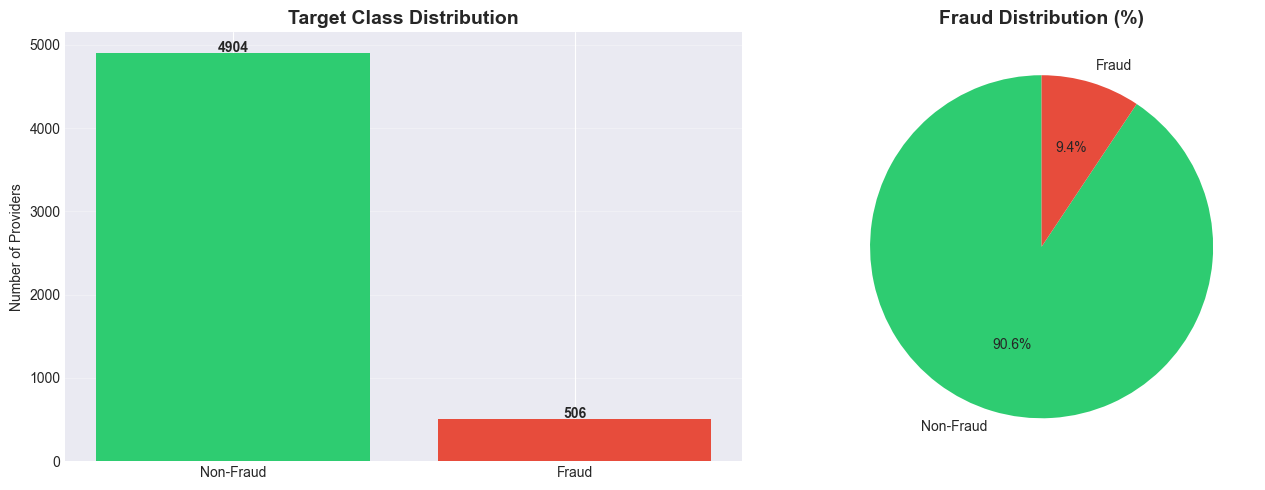

Class Imbalance Ratio: 9.69:1 (Non-Fraud:Fraud)


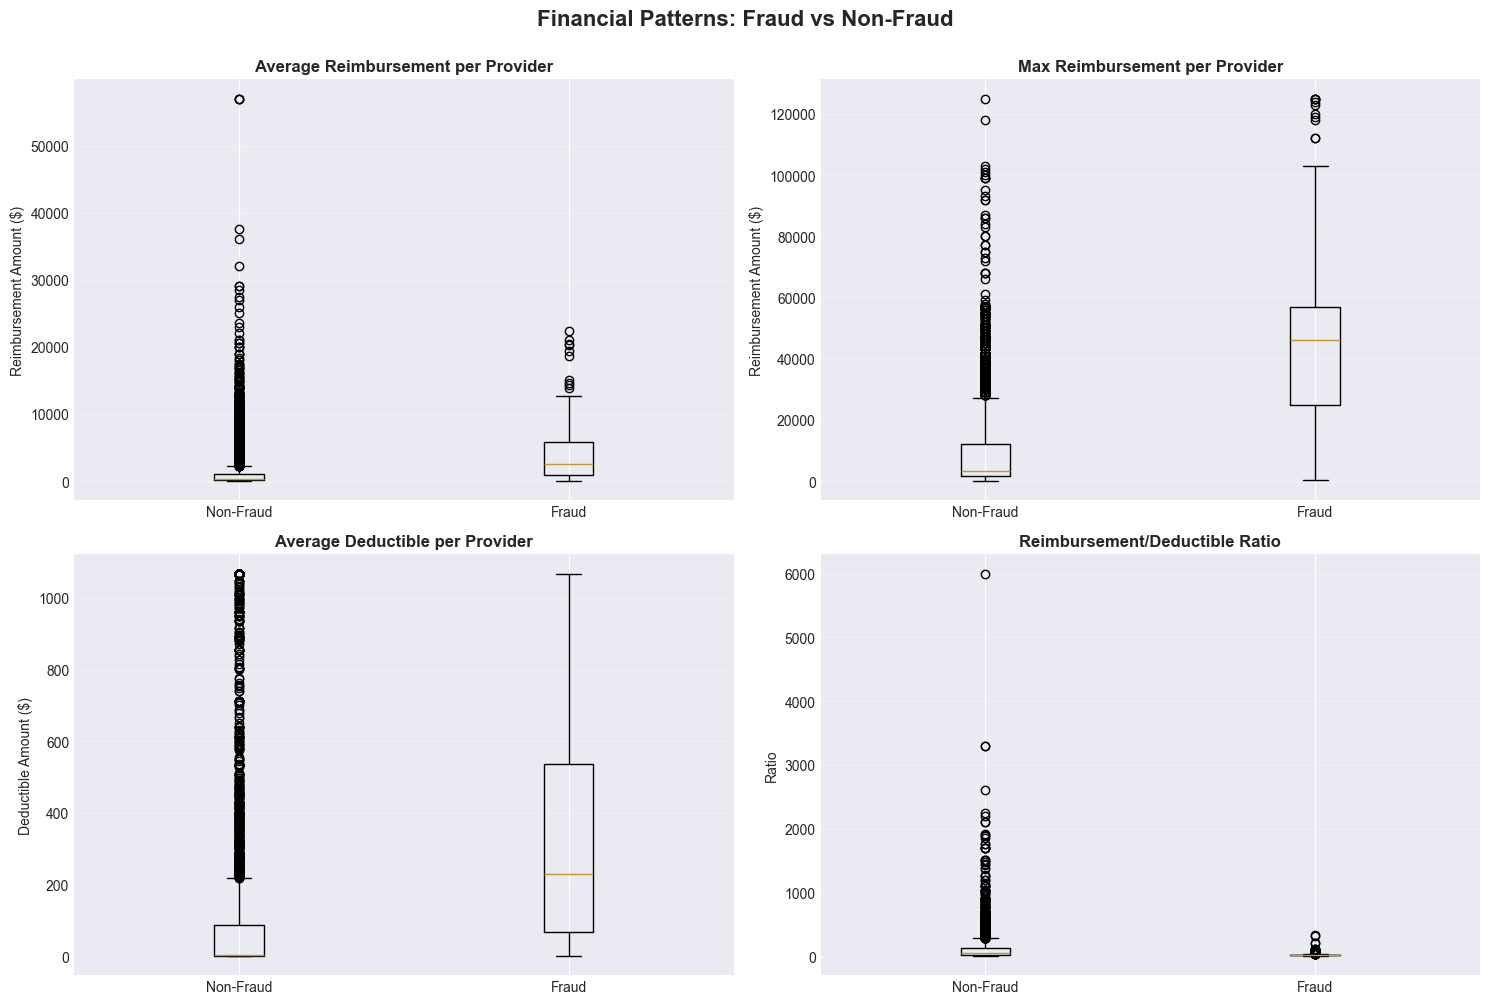

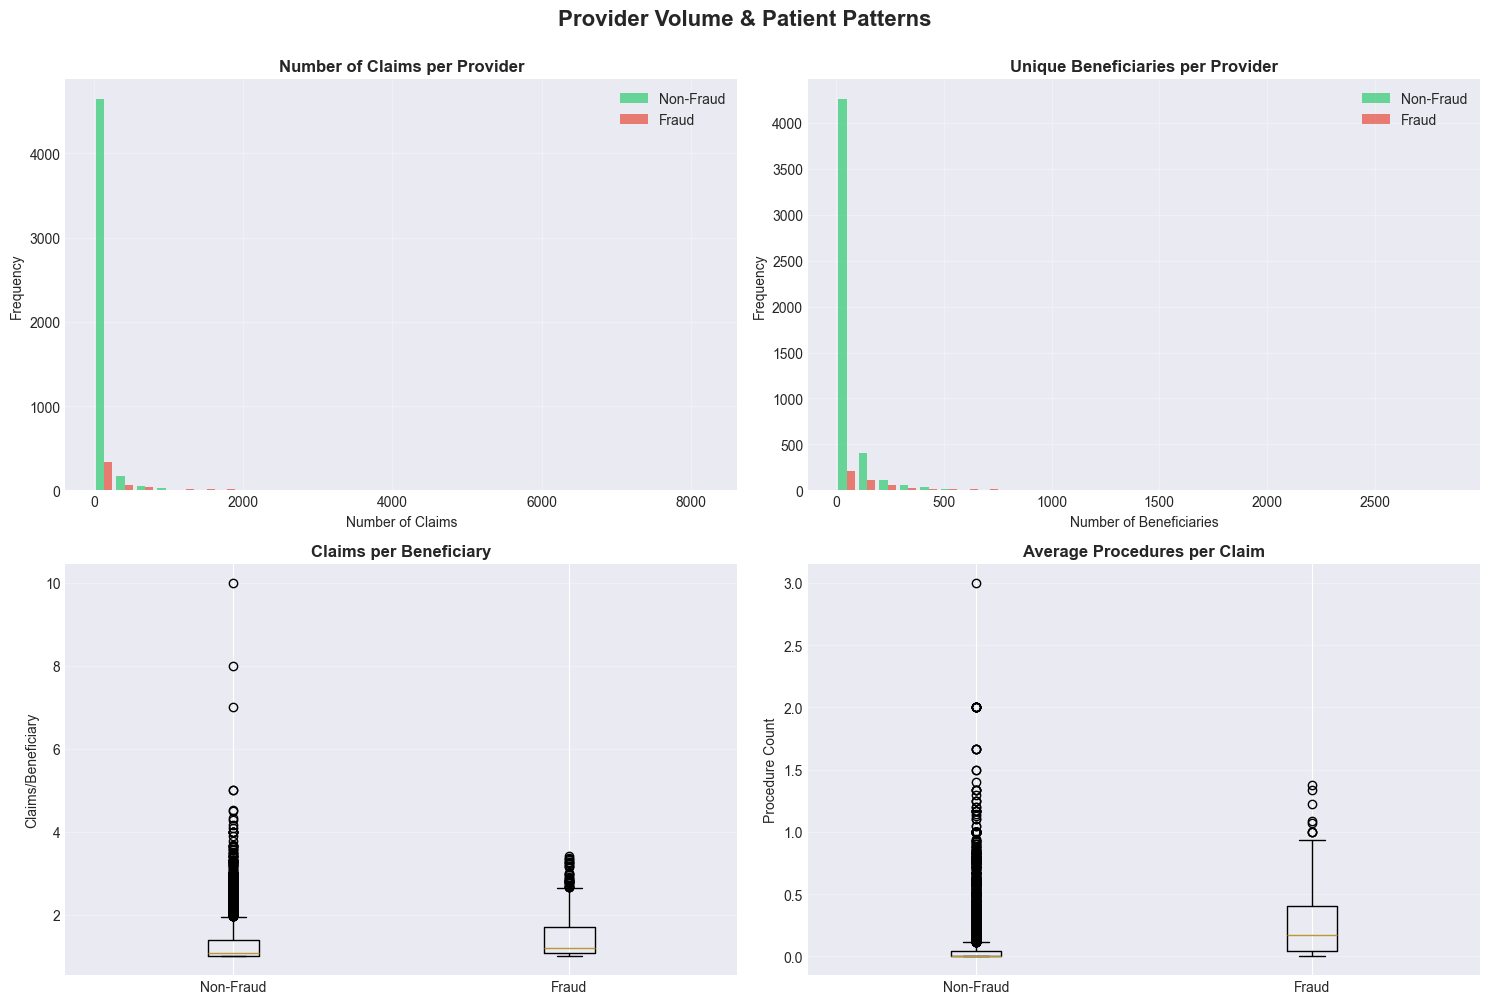

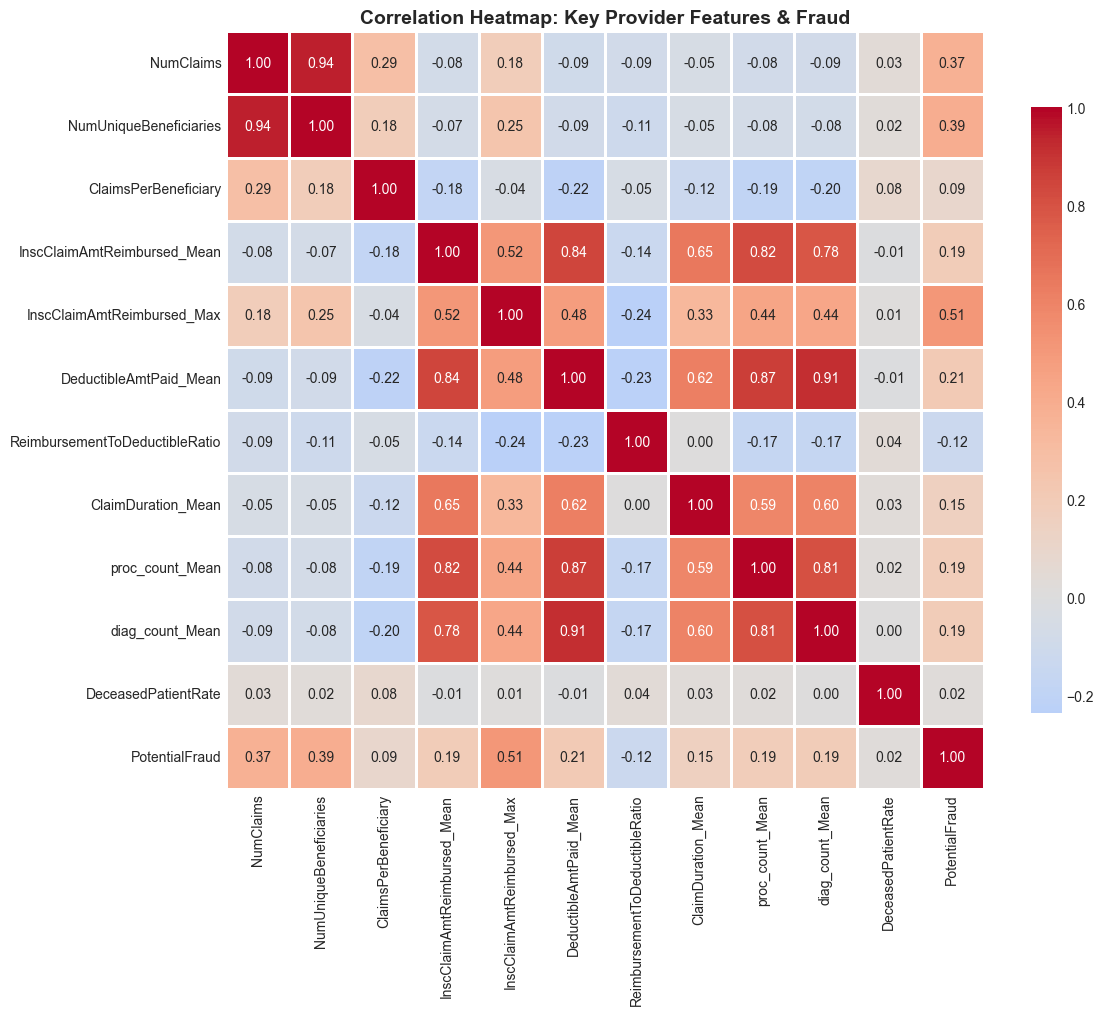


TOP CORRELATIONS WITH FRAUD
PotentialFraud                    1.00
InscClaimAmtReimbursed_Max        0.51
NumUniqueBeneficiaries            0.39
NumClaims                         0.37
DeductibleAmtPaid_Mean            0.21
InscClaimAmtReimbursed_Mean       0.19
diag_count_Mean                   0.19
proc_count_Mean                   0.19
ClaimDuration_Mean                0.15
ClaimsPerBeneficiary              0.09
DeceasedPatientRate               0.02
ReimbursementToDeductibleRatio   -0.12
Name: PotentialFraud, dtype: float64

VISUALIZATION COMPLETE


In [16]:
# 1. TARGET CLASS DISTRIBUTION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud vs Non-Fraud counts
fraud_counts = train_provider_final['PotentialFraud'].value_counts()
axes[0].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Target Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Providers')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Fraud percentage pie chart
axes[1].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Fraud Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {fraud_counts[0] / fraud_counts[1]:.2f}:1 (Non-Fraud:Fraud)")


# 2. CLAIM AMOUNT TRENDS (Fraud vs Non-Fraud)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average Reimbursement
axes[0, 0].boxplot([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['InscClaimAmtReimbursed_Mean'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['InscClaimAmtReimbursed_Mean'].dropna()
], labels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_title('Average Reimbursement per Provider', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Reimbursement Amount ($)')
axes[0, 0].grid(axis='y', alpha=0.3)

# Max Reimbursement
axes[0, 1].boxplot([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['InscClaimAmtReimbursed_Max'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['InscClaimAmtReimbursed_Max'].dropna()
], labels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('Max Reimbursement per Provider', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Reimbursement Amount ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Average Deductible
axes[1, 0].boxplot([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['DeductibleAmtPaid_Mean'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['DeductibleAmtPaid_Mean'].dropna()
], labels=['Non-Fraud', 'Fraud'])
axes[1, 0].set_title('Average Deductible per Provider', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Deductible Amount ($)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Reimbursement to Deductible Ratio
axes[1, 1].boxplot([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['ReimbursementToDeductibleRatio'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['ReimbursementToDeductibleRatio'].dropna()
], labels=['Non-Fraud', 'Fraud'])
axes[1, 1].set_title('Reimbursement/Deductible Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Financial Patterns: Fraud vs Non-Fraud', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


# 3. PROVIDER-LEVEL SUMMARIES
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Claims per Provider
axes[0, 0].hist([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['NumClaims'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['NumClaims'].dropna()
], bins=30, label=['Non-Fraud', 'Fraud'], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 0].set_title('Number of Claims per Provider', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Claims')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Unique Beneficiaries per Provider
axes[0, 1].hist([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['NumUniqueBeneficiaries'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['NumUniqueBeneficiaries'].dropna()
], bins=30, label=['Non-Fraud', 'Fraud'], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 1].set_title('Unique Beneficiaries per Provider', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Beneficiaries')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Claims per Beneficiary
axes[1, 0].boxplot([
    train_provider_final[train_provider_final['PotentialFraud'] == 0]['ClaimsPerBeneficiary'].dropna(),
    train_provider_final[train_provider_final['PotentialFraud'] == 1]['ClaimsPerBeneficiary'].dropna()
], labels=['Non-Fraud', 'Fraud'])
axes[1, 0].set_title('Claims per Beneficiary', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Claims/Beneficiary')
axes[1, 0].grid(axis='y', alpha=0.3)

# Procedure Count (alternative to DeceasedPatientRate)
if 'proc_count_Mean' in train_provider_final.columns:
    axes[1, 1].boxplot([
        train_provider_final[train_provider_final['PotentialFraud'] == 0]['proc_count_Mean'].dropna(),
        train_provider_final[train_provider_final['PotentialFraud'] == 1]['proc_count_Mean'].dropna()
    ], labels=['Non-Fraud', 'Fraud'])
    axes[1, 1].set_title('Average Procedures per Claim', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Procedure Count')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Provider Volume & Patient Patterns', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


# 4. CORRELATION HEATMAP (Top Features)
# Select key numeric features for correlation
key_features = [
    'NumClaims', 'NumUniqueBeneficiaries', 'ClaimsPerBeneficiary',
    'InscClaimAmtReimbursed_Mean', 'InscClaimAmtReimbursed_Max',
    'DeductibleAmtPaid_Mean', 'ReimbursementToDeductibleRatio',
    'ClaimDuration_Mean', 'proc_count_Mean', 'diag_count_Mean',
    'DeceasedPatientRate', 'PotentialFraud'
]

# Filter only existing columns
existing_features = [col for col in key_features if col in train_provider_final.columns]
corr_data = train_provider_final[existing_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Key Provider Features & Fraud', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show correlations with fraud target
fraud_corr = corr_data['PotentialFraud'].sort_values(ascending=False)
print(f"\n{'='*60}")
print("TOP CORRELATIONS WITH FRAUD")
print(f"{'='*60}")
print(fraud_corr)


# 5. CHRONIC CONDITION PATTERNS
chronic_condition_cols = [col for col in train_provider_final.columns if col.endswith('_Count')]

if len(chronic_condition_cols) > 0:
    # Select top 5 most common chronic conditions
    chronic_means = train_provider_final[chronic_condition_cols].mean().sort_values(ascending=False).head(5)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Average chronic condition counts by fraud status
    fraud_chronic = train_provider_final[train_provider_final['PotentialFraud'] == 1][chronic_means.index].mean()
    non_fraud_chronic = train_provider_final[train_provider_final['PotentialFraud'] == 0][chronic_means.index].mean()
    
    x = np.arange(len(chronic_means.index))
    width = 0.35
    
    axes[0].bar(x - width/2, non_fraud_chronic.values, width, label='Non-Fraud', color='#2ecc71')
    axes[0].bar(x + width/2, fraud_chronic.values, width, label='Fraud', color='#e74c3c')
    axes[0].set_xlabel('Chronic Condition')
    axes[0].set_ylabel('Average Patient Count')
    axes[0].set_title('Top 5 Chronic Conditions: Fraud vs Non-Fraud', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([col.replace('ChronicCond_', '').replace('_Count', '') 
                              for col in chronic_means.index], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Total chronic patient counts
    axes[1].bar(range(len(chronic_means)), chronic_means.values, color='steelblue')
    axes[1].set_xlabel('Chronic Condition')
    axes[1].set_ylabel('Average Patient Count (All Providers)')
    axes[1].set_title('Most Common Chronic Conditions', fontsize=12, fontweight='bold')
    axes[1].set_xticks(range(len(chronic_means)))
    axes[1].set_xticklabels([col.replace('ChronicCond_', '').replace('_Count', '') 
                              for col in chronic_means.index], rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print("VISUALIZATION COMPLETE")
print(f"{'='*60}")

## Geographic Patterns Analysis

GEOGRAPHIC PATTERNS BY STATE

Top 10 States by Fraud Rate:
       Fraud  Non-Fraud  Total  FraudRate
State                                    
9         28         61     89      31.46
41        23         51     74      31.08
8         29         68     97      29.90
12        24         60     84      28.57
29        84        226    310      27.10
30        32         94    126      25.40
31        83        252    335      24.78
6         40        122    162      24.69
44        58        182    240      24.17
13        26         82    108      24.07


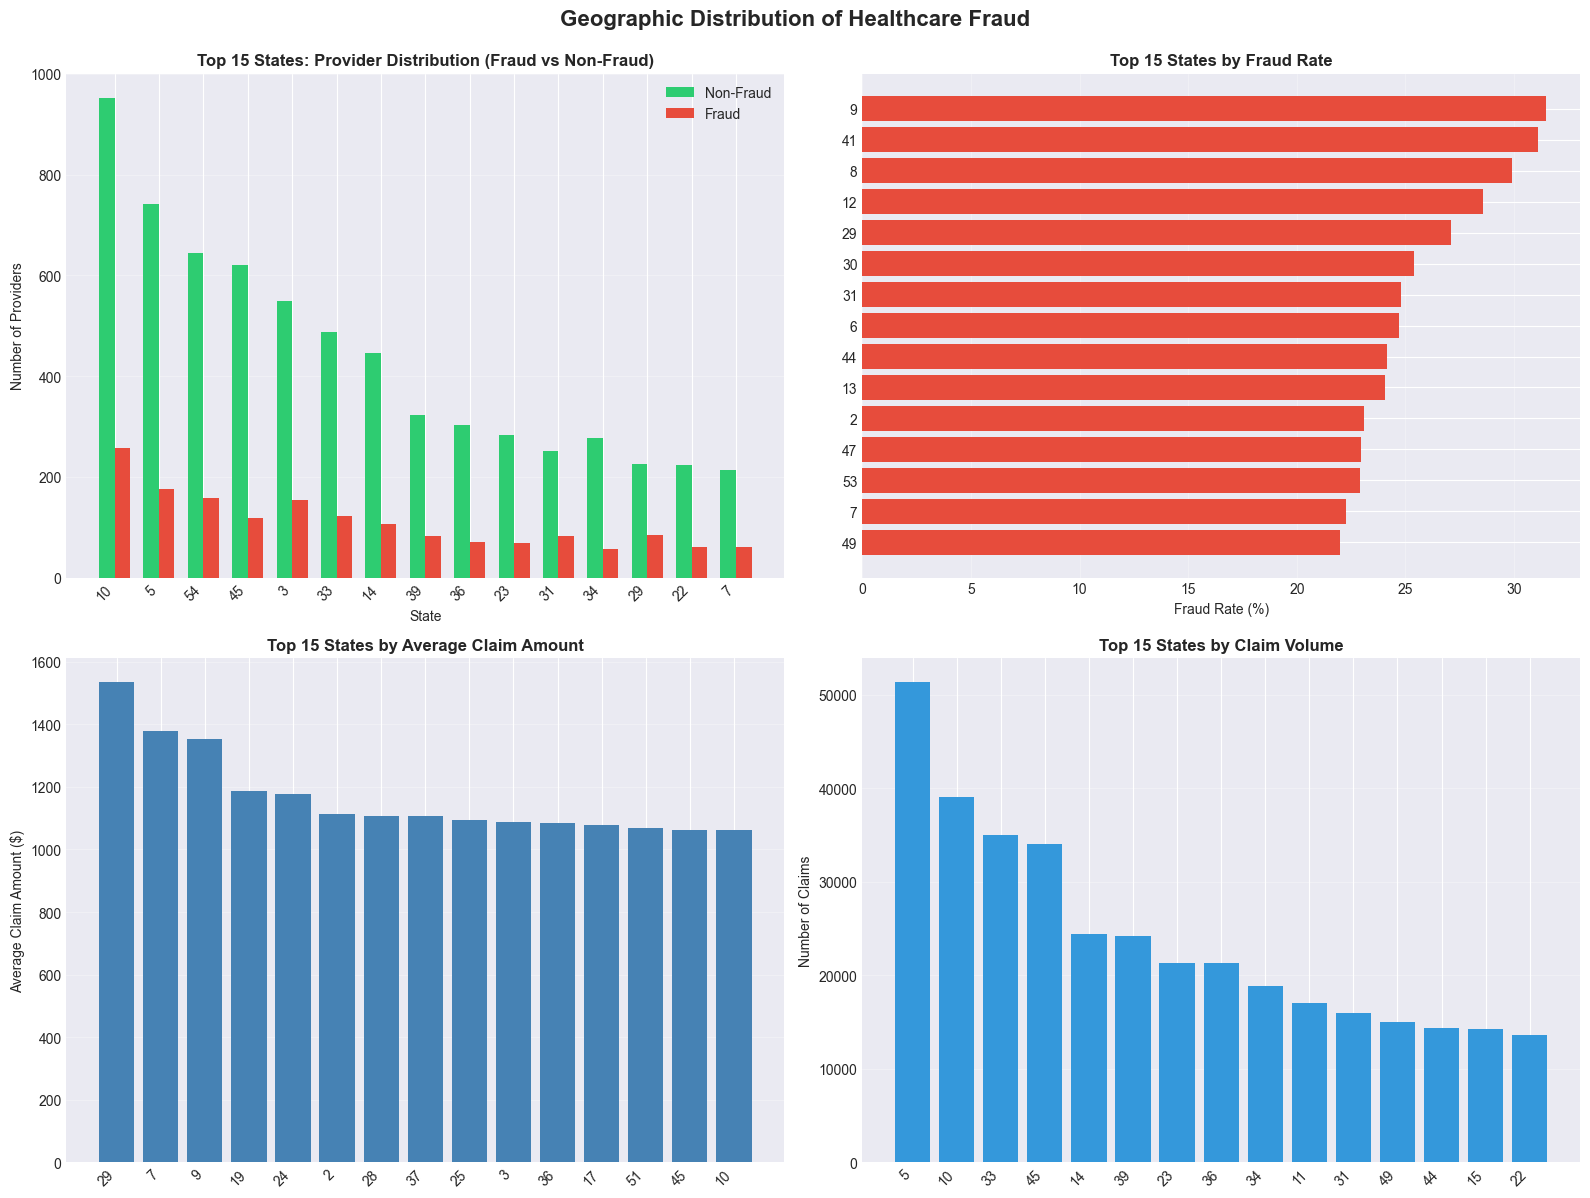


GEOGRAPHIC SUMMARY STATISTICS
Total states: 52
Highest fraud rate: 31.46% (9)
Lowest fraud rate: 9.84% (19)
Average fraud rate across states: 19.91%


In [17]:
# Analyze geographic patterns from the merged claim-level data (before aggregation)
# Merge train claims with labels to get fraud status at claim level
train_claims_with_labels = train_final_merged.merge(train_labels, on='Provider', how='left')
train_claims_with_labels['PotentialFraud'] = train_claims_with_labels['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Check if State column exists
if 'State' in train_claims_with_labels.columns:
    print("="*60)
    print("GEOGRAPHIC PATTERNS BY STATE")
    print("="*60)
    
    # 1. Provider count by state and fraud status
    state_fraud_counts = train_claims_with_labels.groupby(['State', 'PotentialFraud'])['Provider'].nunique().reset_index()
    state_fraud_counts.columns = ['State', 'PotentialFraud', 'ProviderCount']
    
    # Pivot for visualization
    state_pivot = state_fraud_counts.pivot(index='State', columns='PotentialFraud', values='ProviderCount').fillna(0)
    state_pivot.columns = ['Non-Fraud', 'Fraud']
    
    # Calculate fraud rate by state
    state_pivot['Total'] = state_pivot['Non-Fraud'] + state_pivot['Fraud']
    state_pivot['FraudRate'] = (state_pivot['Fraud'] / state_pivot['Total'] * 100).round(2)
    state_pivot = state_pivot.sort_values('FraudRate', ascending=False)
    
    print(f"\nTop 10 States by Fraud Rate:")
    print(state_pivot[['Fraud', 'Non-Fraud', 'Total', 'FraudRate']].head(10))
    
    # 2. VISUALIZATION: Geographic Distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top 15 states by provider count
    top_states = state_pivot.nlargest(15, 'Total')
    
    # Plot 1: Provider counts by state
    x = np.arange(len(top_states))
    width = 0.35
    axes[0, 0].bar(x - width/2, top_states['Non-Fraud'], width, label='Non-Fraud', color='#2ecc71')
    axes[0, 0].bar(x + width/2, top_states['Fraud'], width, label='Fraud', color='#e74c3c')
    axes[0, 0].set_xlabel('State')
    axes[0, 0].set_ylabel('Number of Providers')
    axes[0, 0].set_title('Top 15 States: Provider Distribution (Fraud vs Non-Fraud)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(top_states.index, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Fraud rate by state (top 15)
    top_fraud_rate_states = state_pivot.nlargest(15, 'FraudRate')
    axes[0, 1].barh(range(len(top_fraud_rate_states)), top_fraud_rate_states['FraudRate'], color='#e74c3c')
    axes[0, 1].set_yticks(range(len(top_fraud_rate_states)))
    axes[0, 1].set_yticklabels(top_fraud_rate_states.index)
    axes[0, 1].set_xlabel('Fraud Rate (%)')
    axes[0, 1].set_title('Top 15 States by Fraud Rate', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    
    # Plot 3: Average claim amount by state (top 15)
    state_claim_amounts = train_claims_with_labels.groupby('State').agg({
        'InscClaimAmtReimbursed': 'mean',
        'PotentialFraud': 'mean'
    }).sort_values('InscClaimAmtReimbursed', ascending=False).head(15)
    
    axes[1, 0].bar(range(len(state_claim_amounts)), state_claim_amounts['InscClaimAmtReimbursed'], 
                   color='steelblue')
    axes[1, 0].set_xticks(range(len(state_claim_amounts)))
    axes[1, 0].set_xticklabels(state_claim_amounts.index, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Average Claim Amount ($)')
    axes[1, 0].set_title('Top 15 States by Average Claim Amount', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot 4: Claims per state (top 15)
    state_claim_counts = train_claims_with_labels.groupby('State').size().sort_values(ascending=False).head(15)
    axes[1, 1].bar(range(len(state_claim_counts)), state_claim_counts.values, color='#3498db')
    axes[1, 1].set_xticks(range(len(state_claim_counts)))
    axes[1, 1].set_xticklabels(state_claim_counts.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Number of Claims')
    axes[1, 1].set_title('Top 15 States by Claim Volume', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Geographic Distribution of Healthcare Fraud', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("GEOGRAPHIC SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total states: {len(state_pivot)}")
    print(f"Highest fraud rate: {state_pivot['FraudRate'].max():.2f}% ({state_pivot['FraudRate'].idxmax()})")
    print(f"Lowest fraud rate: {state_pivot['FraudRate'].min():.2f}% ({state_pivot['FraudRate'].idxmin()})")
    print(f"Average fraud rate across states: {state_pivot['FraudRate'].mean():.2f}%")
    
else:
    print("⚠️ State column not found in the data. Geographic analysis requires State information.")
    print("State column may have been dropped during data processing.")